## Table of Contents

1. [Introduction](#introduction)
2. [Data Overview](#data-overview)
   - 2.1. Number of Tested Isolates
   - 2.2. Number of Features
3. [Unique Feature Values](#unique-feature-values)
   - 3.1. Categorical Features
   - 3.2. Numerical Features
4. [Histograms of Numerical Feature Distributions](#histograms-of-numerical-feature-distributions)
5. [Correlations and Simple Dependencies](#correlations-and-simple-dependencies)

<br>

---

<h2 id="introduction">Introduction</h2>

Dataset from : [Antimicrobial resistance data](https://www.kaggle.com/datasets/amritpal333/antimicrobial-resistance-data/code)

Based on the presented data, the task is to predict the sensitivity and resistance of major microorganism types to specific drugs.

<h2 id="data-overview">Data Overview</h2>

### Number of Tested Isolates




In [ ]:
import os
import sys

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

if 'notebooks' in os.getcwd().split(os.sep):
    os.chdir('..')
    print(f"Перешёл в корень проекта: {os.getcwd()}")

from src.functions import calculate_total_n

data_root = "data\\raw"

def find_excel_files(base_dir):
    file_paths = []
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.endswith('.xlsx'):
                file_paths.append(os.path.join(root, file))
    return file_paths

file_paths = find_excel_files(data_root)

calculate_total_n(file_paths)

Найдено файлов: 61
data\raw\2013\E-Coli\number-3GCREC-percentage-ESBL-2013.xlsx
data\raw\2013\E-Coli\number-e-coli-isolates-and-percentage-combined-resistance-2010-2013.xlsx
data\raw\2013\E-Coli\number-e-coli-isolates-and-percentage-resistant-3-gen-cephalosporins-2010-2013.xlsx
data\raw\2013\E-Coli\number-e-coli-isolates-and-percentage-resistant-aminoglycosides-2010-2013.xlsx
data\raw\2013\E-Coli\number-e-coli-isolates-and-percentage-resistant-aminopenicilins-2010-2013.xlsx
data\raw\2013\E-Coli\number-e-coli-isolates-and-percentage-resistant-carbapenems-2010-2013.xlsx
data\raw\2013\E-Coli\number-e-coli-isolates-and-percentage-resistant-fluoroquinolones-2010-2013.xlsx
data\raw\2013\Enterococci\number-e-faecalis-isolates-and-percentage-high-level-resistance-aminoglycosides-2010-2013.xlsx
data\raw\2013\Enterococci\number-e-faecium-isolates-and-percentage-resistant-vancomycin-2010-2013.xlsx
data\raw\2013\K-Pneumoniae\number-3GCRKP-percentage-ESBL-2013.xlsx
data\raw\2013\K-Pneumoniae\number

In [44]:
import math
import os
import pandas as pd
import re
import warnings
from collections import defaultdict
from IPython.display import display

warnings.filterwarnings("ignore")

# --- Список антибиотиков и алиасы ---
ANTIBIOTICS = [
    "3GCREC", "3GCRKP", "fluoroquinolones", "aminoglycosides", "aminopenicillins",
    "carbapenems", "vancomycin", "piperacillin (+ tazobactam)", "ceftazidime",
    "meticillin", "macrolides", "penicillin", "third-generation cephalosporins",
    "penicillins", "piperacillin(+tazobactam)", "piperacillin+tazobactam",
    "piperacillin±tazobactam", "gentamicin", "piperacillin (+ tazobactam)",
    "piperacillin", "piperacillin + tazobactam", "aminoglycoside"
]

ABX_ALIASES = {
    "piperacillin(+tazobactam)": "piperacillin+tazobactam",
    "piperacillin±tazobactam": "piperacillin+tazobactam",
    "piperacillin (+ tazobactam)": "piperacillin+tazobactam",
    "piperacillin" : "piperacillin+tazobactam",
    "penicillin": "penicillins",
    "piperacillin + tazobactam" : "piperacillin+tazobactam",
    "aminoglycoside" : "aminoglycosides"
}

# --- Список стран ---
countries_list = [
    'Belgium', 'Finland', 'Sweden', 'Ireland', 'Denmark', 'Netherlands',
    'United Kingdom', 'Germany', 'Norway', 'Malta', 'France', 'Austria',
    'Czech Republic', 'Slovakia', 'Portugal', 'Slovenia', 'Spain', 'Hungary',
    'Latvia', 'Bulgaria', 'Italy', 'Romania', 'Cyprus', 'Poland', 'Croatia',
    'Lithuania', 'Greece', 'Estonia', 'Iceland', 'Luxembourg'
]
NORMALIZED_COUNTRIES = {c.lower() for c in countries_list}

# --- Паттерны для N ---
N_PATTERNS = [
    'Number of.1', 'Number of isolates', 'Number of \ntested isolates',
    'Number of tested isolates',
    'Number of \n3GCREC included in analysis/ total number of 3GCREC',
    'Number of\n3GCRKP\nincluded in\nanalysis/total\nnumber of\n3GCRKP',
    'N', 'N.1', 'N.2', 'N.3', 'Number of',
    'Number of laboratories'
]
N_PATTERNS_LOWER = {p.lower() for p in N_PATTERNS}

RESISTANCE_PATTERNS = [
    "% ESBL", "%R", "%R .1", "%R .2", "%R .3",
    "%IR", "%IR .1", "%IR .2", "%IR .3",
    "% of total*", "% of total**"
]

def get_excel_files(base_dir):
    """Возвращает список путей к Excel-файлам в директории."""
    for root, _, files in os.walk(base_dir):
        for file in files:
            if file.endswith('.xlsx'):
                yield os.path.join(root, file).replace("\\", "/")


def extract_year_from_path(path):
    """Извлекает год из пути к файлу."""
    parts = path.split("/")
    return parts[3] if len(parts) > 3 else "unknown"


def get_sheet_names(path, year):
    """Возвращает список листов Excel-файла (только для 2015)."""
    return pd.ExcelFile(path).sheet_names if year == '2015' else [None]


def process_excel_file(path, year, sheet=None):
    """Считывает DataFrame из Excel-файла."""
    df = pd.read_excel(path, sheet_name=sheet, header=None)
    # Если случайно вернулся dict — берём первый лист
    if isinstance(df, dict):
        return list(df.values())[0]
    return df


def get_first_nonempty_row(df):
    """Возвращает первую непустую строку в DataFrame."""
    for i, row in df.iterrows():
        values = row.dropna().astype(str).tolist()
        if values:
            return " ".join(values)
    return None


def extract_antibiotics(text):
    """Извлекает антибиотики из строки на основе точных совпадений с учетом границ слова."""
    found = set()
    text_lower = text.lower()
    for abx in ANTIBIOTICS:
        normalized = abx.lower()
        # экранируем спецсимволы в названии, если они есть
        pattern = r'\b{}\b'.format(re.escape(normalized))
        if re.search(pattern, text_lower):
            found.add(ABX_ALIASES.get(abx, abx).lower())
    return sorted(found)

def process_dataframe(df, year):
    """Обрабатывает один DataFrame и возвращает список записей."""
    result = []
    iterator = 0
    first_line = get_first_nonempty_row(df)
    if not first_line:
        return result

    microorganism = re.split(r"[.]", first_line)[0].strip()
    abx_list = extract_antibiotics(first_line)
    abx_list = [ABX_ALIASES.get(abx.strip(), abx.strip()) for abx in abx_list]
    abx_str = ", ".join(abx_list)

    country_row_idx = find_country_header_row(df)

    # Если нет колонки с Country - обрабатываем как общие данные
    if country_row_idx is None:
        return process_country_agnostic_data(
            df, microorganism, abx_str, year
        )

    # Оригинальная обработка для таблиц с Country
    header_row = df.iloc[country_row_idx].astype(str).fillna("")
    resistance_col_dict = get_resistance_columns(header_row,year)
    country_col_idx = next(
        (idx for idx, val in enumerate(header_row) if 'country' in val.lower()), None
    )

    n_col_dict = get_valid_n_columns(header_row, year, df, country_row_idx)
    if not n_col_dict:
        return result

    for target_year, col_info in n_col_dict.items():
        result.extend(
            extract_country_data(
                df, country_row_idx, country_col_idx, col_info,
                microorganism, abx_str, target_year, resistance_col_dict, iterator
            )
        )
        iterator += 1
    return result

def process_country_agnostic_data(df, microorganism, abx_str, year):
    """Обрабатывает таблицы без колонки Country с разделением fully susceptible."""
    result = []
    
    # 1. Находим заголовки данных и колонку resistance pattern
    header_row_idx = find_first_data_header(df)
    if header_row_idx is None:
        return result
    
    header_row = df.iloc[header_row_idx].astype(str).str.strip()
    
    # 2. Ищем колонку resistance pattern
    resistance_pattern_col = None
    for idx, val in enumerate(header_row):
        if "resistance pattern" in val.lower():
            resistance_pattern_col = idx
            break
    
    # 3. Идентифицируем колонки с данными
    n_cols = [idx for idx, val in enumerate(header_row) 
              if val.lower() in {p.lower() for p in N_PATTERNS}]
    resistance_cols = [idx for idx, val in enumerate(header_row)
                      if val.lower() in {p.lower() for p in RESISTANCE_PATTERNS}]
    
    # 4. Обрабатываем каждую строку данных
    for row_idx in range(header_row_idx + 1, len(df)):
        row = df.iloc[row_idx]
        
        # 5. Определяем fully susceptible
        is_fully_susceptible = False
        if resistance_pattern_col is not None and resistance_pattern_col < len(row):
            pattern_value = str(row[resistance_pattern_col]).strip().lower()
            if "fully susceptible" in pattern_value:
                is_fully_susceptible = True

        # 6. Обработка антибиотиков
        current_abx = abx_str
        if resistance_pattern_col is not None and resistance_pattern_col < len(row) and not is_fully_susceptible:
            pattern_value = str(row[resistance_pattern_col]).strip().lower()
            matched_abx = []

            for abx in ANTIBIOTICS:
                normalized = abx.lower()
                pattern = r'\b{}\b'.format(re.escape(normalized))
                if re.search(pattern, pattern_value):
                    # Добавляем по алиасу (если есть), иначе как есть
                    resolved = ABX_ALIASES.get(abx, abx)
                    matched_abx.append(resolved)

            if matched_abx:
                current_abx = ", ".join(sorted(set(matched_abx)))
            else:
                continue  # Пропускаем строку, если ничего не найдено

        # 7. Извлекаем значения резистентности
        resistance_values = {}
        for r_idx in resistance_cols:
            if r_idx < len(row) and not pd.isna(row[r_idx]):
                col_name = header_row[r_idx]
                resistance_values[col_name] = row[r_idx]

        # 8. Определяем значения для fully susceptible и %R
        fully_susceptible_value = None
        r_value = None
        
        if is_fully_susceptible:
            # Для fully susceptible строк берем значение из % of total* или % of total**
            if "% of total*" in resistance_values:
                fully_susceptible_value = resistance_values["% of total*"]
            elif "% of total**" in resistance_values:
                fully_susceptible_value = resistance_values["% of total**"]
        else:
            # Для resistant строк
            if "% of total*" in resistance_values:
                r_value = resistance_values["% of total*"]
            elif "% of total**" in resistance_values:
                r_value = resistance_values["% of total**"]

        # 9. Извлекаем N значение (пропускаем строки с NaN)
        n_value = None
        for n_col in n_cols:
            if n_col < len(row) and not pd.isna(row[n_col]):
                n_value = row[n_col]
                if isinstance(n_value, str):
                    n_value = n_value.split('/')[0].strip()
                break
        
        if pd.isna(n_value):
            continue
            
        # 10. Создаем запись
        record = {
            "Microorganism": microorganism,
            "Antibiotics": current_abx,
            "Year": year,
            "Country": "EU Total",
            "N": n_value,
            "Fully susceptible": fully_susceptible_value,
            "%R": r_value,
            "%ESBL": resistance_values.get("% ESBL"),
            "Non-susceptible": None, 
            "Number of laboratories": None
        }
        
        result.append(record)
    
    return result

def find_first_data_header(df):
    """Находит первую строку с заголовками данных."""
    for i in range(len(df)):
        row = df.iloc[i].astype(str).str.strip()
        if any(val.lower() in N_PATTERNS_LOWER for val in row):
            return i
    return None

def find_country_header_row(df):
    for i in range(len(df)):
        row = df.iloc[i]
        if row.astype(str).str.contains("(?i)^country$").any():
            return i
    return None

def get_valid_n_columns(header_row, year, df=None, header_row_idx=None):
    """Возвращает словарь с годами и индексами колонок 'N' и 'Number of laboratories'."""
    n_cols = []
    lab_cols = []

    for idx, val in enumerate(header_row):
        if "laboratories" in val.strip().lower():
            lab_cols.append(idx)
            continue
        if val.strip().lower() in {p.lower() for p in N_PATTERNS}:
            if df is not None and header_row_idx is not None:
                # Проверка следующей строки
                try:
                    next_val = str(df.iloc[header_row_idx + 1, idx]).strip().lower()
                    if next_val == "laboratories":
                        lab_cols.append(idx)
                        continue  # Считаем это колонкой для лабораторий
                except Exception:
                    pass
            n_cols.append(idx)
    if year == '2013':
        if len(n_cols) < 4:
            return {year: {"n": [2] if n_cols else [], "labs": lab_cols}}
        years = ['2010', '2011', '2012', '2013']
        return {y: {"n": [col], "labs": []} for y, col in zip(years, n_cols[:4])}
    elif year in {'2014', '2015'}:
        return {year: {"n": [n_cols[-1]] if n_cols else [], "labs": lab_cols}}
    else:
        return {}
    

def get_resistance_columns(header_row, year):
    r_cols = []
    ir_detected = set()

    for idx, val in enumerate(header_row):
        val_clean = val.strip().lower()

        if val_clean in {p.lower() for p in RESISTANCE_PATTERNS}:
            r_cols.append(idx)
            if val_clean.startswith("%ir"):
                ir_detected.add(idx)
    return {
        "resistance": r_cols,
        "ir_indices": list(ir_detected)
    }
    
   
from collections import defaultdict
def extract_country_data(df, start_row, country_col_idx, col_info, microorganism, abx_str, year, resistance_col_dict, iterator):
    """Извлекает данные по странам из таблицы, учитывая resistance pattern и антибиотики."""
    rows = []

    # Находим колонку resistance pattern
    resistance_pattern_col = None
    for idx, val in enumerate(df.iloc[start_row]):
        if isinstance(val, str) and "resistance pattern" in val.lower():
            resistance_pattern_col = idx
            break

    for i in range(start_row + 1, len(df)):
        row = df.iloc[i]
        
        # Проверка страны
        country_cell = row.iloc[country_col_idx] if country_col_idx is not None and country_col_idx < len(row) else None
        if pd.isna(country_cell) or not isinstance(country_cell, str):
            continue
        normalized = country_cell.strip().lower()
        if normalized not in NORMALIZED_COUNTRIES:
            continue

        # Обработка антибиотиков
        current_abx = abx_str
        if resistance_pattern_col is not None and resistance_pattern_col < len(row):
            pattern_value = str(row.iloc[resistance_pattern_col]).strip().lower()
            matched_abx = []
            for abx in abx_str.split(", "):
                abx_normalized = ABX_ALIASES.get(abx, abx).lower()
                if abx_normalized in pattern_value:
                    matched_abx.append(abx)
            if matched_abx:
                current_abx = ", ".join(matched_abx)
            else:
                continue  # Пропускаем строку, если антибиотики не найдены

        # Извлекаем значения резистентности
        resistance_values = defaultdict(list)
        for r_idx in resistance_col_dict.get("resistance", []):
            if r_idx < len(row):
                col_name = df.iloc[start_row, r_idx].strip()
                resistance_values[col_name].append(row.iloc[r_idx])

        # Обработка N и лабораторий
        for n_idx in col_info["n"]:
            n_value = row.iloc[n_idx] if n_idx < len(row) else None
            if isinstance(n_value, str):
                n_value = n_value.split('/')[0]

            labs_value = None
            for lab_idx in col_info["labs"]:
                if lab_idx < len(row):
                    labs_value = row.iloc[lab_idx]
                    if isinstance(labs_value, str):
                        labs_value = labs_value.split('/')[0]
                    break

            # Определяем значение для %R
            if year in ['2014', '2015']:
                # Берем последние значения для %R и %IR
                r_value = resistance_values.get("%R", [None])[-1]
                ir_value = resistance_values.get("%IR", [None])[-1]
            else:
                # Используем iterator для других годов
                r_value = resistance_values.get("%R", [None])[iterator] if iterator < len(resistance_values.get("%R", [])) else None
                ir_value = resistance_values.get("%IR", [None])[iterator] if iterator < len(resistance_values.get("%IR", [])) else None

            rows.append({
                "Microorganism": microorganism,
                "Antibiotics": current_abx,
                "Year": year,
                "Country": country_cell.strip(),
                "%ESBL": resistance_values.get("% ESBL", [None])[iterator] if iterator < len(resistance_values.get("% ESBL", [])) else None,
                "%R": r_value,
                "Non-susceptible": ir_value,
                "N": n_value,
                "Fully susceptible": None,
                "Number of laboratories": labs_value
            })

    return rows


def build_microorganism_antibiotic_table(base_dir):
    """Главная функция: собирает таблицу из всех Excel-файлов."""
    data = []
    for path in get_excel_files(base_dir):
        year = extract_year_from_path(path)
        sheets = get_sheet_names(path, year)

        for sheet in sheets:
            df = process_excel_file(path, year, sheet)
            data.extend(process_dataframe(df, year))

    # Создаём финальный DataFrame с нужным порядком колонок
    df = pd.DataFrame(data)
    
    # Убедимся, что все колонки существуют
    for col in ["Fully susceptible", "Non-susceptible"]:
        if col not in df.columns:
            df[col] = None
    
    return df[[
        "Microorganism", "Antibiotics", "Year", "Country", "N",
        "%R", "Fully susceptible", "%ESBL", "Non-susceptible",
        "Number of laboratories"
    ]]

def build_microorganism_antibiotic_table(base_dir):
    """Главная функция: собирает таблицу из всех Excel-файлов."""
    data = []
    for path in get_excel_files(base_dir):
        year = extract_year_from_path(path)
        sheets = get_sheet_names(path, year)

        for sheet in sheets:
            df = process_excel_file(path, year, sheet)
            data.extend(process_dataframe(df, year))

    # Создаём финальный DataFrame с нужным порядком колонок
    df = pd.DataFrame(data)
    columns_order = [
        "Microorganism", "Antibiotics", "Year", "Country", "N",
        "%R", "Fully susceptible", "%ESBL", "Non-susceptible",
        "Number of laboratories"
    ]
    # Добавляем колонку, если её нет (для старых данных)
    if "Fully susceptible" not in df.columns:
        df["Fully susceptible"] = None
    
    return df[columns_order]



def build_microorganism_antibiotic_table(base_dir):
    """Главная функция: собирает таблицу из всех Excel-файлов."""
    data = []
    for path in get_excel_files(base_dir):
        year = extract_year_from_path(path)
        sheets = get_sheet_names(path, year)

        for sheet in sheets:
            df = process_excel_file(path, year, sheet)
            data.extend(process_dataframe(df, year))

    # Создаём финальный DataFrame с нужным порядком колонок
    df = pd.DataFrame(data)
    return df[[
        "Microorganism", "Antibiotics", "Year", "Country", "N",
        "%R", "Fully susceptible", "%ESBL", "Non-susceptible",
        "Number of laboratories"
    ]]


# ✅ Запуск для теста
if __name__ == "__main__":
    base_dir = "../data/raw"
    df = build_microorganism_antibiotic_table(base_dir)

    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_colwidth', None)
    
    df["N"] = pd.to_numeric(df["N"], errors="coerce")
    total = df["N"].sum()
    print(total)
    display(df)

4277344.0


Microorganism  \
0             Escherichia coli   
1             Escherichia coli   
2             Escherichia coli   
3             Escherichia coli   
4             Escherichia coli   
5             Escherichia coli   
6             Escherichia coli   
7             Escherichia coli   
8             Escherichia coli   
9             Escherichia coli   
10            Escherichia coli   
11            Escherichia coli   
12            Escherichia coli   
13            Escherichia coli   
14            Escherichia coli   
15            Escherichia coli   
16            Escherichia coli   
17            Escherichia coli   
18            Escherichia coli   
19            Escherichia coli   
20            Escherichia coli   
21            Escherichia coli   
22            Escherichia coli   
23            Escherichia coli   
24            Escherichia coli   
25            Escherichia coli   
26            Escherichia coli   
27            Escherichia coli   
28            Escherichia coli   
29            Escherichia coli   
30            Escherichia coli   
31            Escherichia coli   
32            Escherichia coli   
33            Escherichia coli   
34            Escherichia coli   
35            Escherichia coli   
36            Escherichia coli   
37            Escherichia coli   
38            Escherichia coli   
39            Escherichia coli   
40            Escherichia coli   
41            Escherichia coli   
42            Escherichia coli   
43            Escherichia coli   
44            Escherichia coli   
45            Escherichia coli   
46            Escherichia coli   
47            Escherichia coli   
48            Escherichia coli   
49            Escherichia coli   
50            Escherichia coli   
51            Escherichia coli   
52            Escherichia coli   
53            Escherichia coli   
54            Escherichia coli   
55            Escherichia coli   
56            Escherichia coli   
57            Escherichia coli   
58            Escherichia coli   
59            Escherichia coli   
60            Escherichia coli   
61            Escherichia coli   
62            Escherichia coli   
63            Escherichia coli   
64            Escherichia coli   
65            Escherichia coli   
66            Escherichia coli   
67            Escherichia coli   
68            Escherichia coli   
69            Escherichia coli   
70            Escherichia coli   
71            Escherichia coli   
72            Escherichia coli   
73            Escherichia coli   
74            Escherichia coli   
75            Escherichia coli   
76            Escherichia coli   
77            Escherichia coli   
78            Escherichia coli   
79            Escherichia coli   
80            Escherichia coli   
81            Escherichia coli   
82            Escherichia coli   
83            Escherichia coli   
84            Escherichia coli   
85            Escherichia coli   
86            Escherichia coli   
87            Escherichia coli   
88            Escherichia coli   
89            Escherichia coli   
90            Escherichia coli   
91            Escherichia coli   
92            Escherichia coli   
93            Escherichia coli   
94            Escherichia coli   
95            Escherichia coli   
96            Escherichia coli   
97            Escherichia coli   
98            Escherichia coli   
99            Escherichia coli   
100           Escherichia coli   
101           Escherichia coli   
102           Escherichia coli   
103           Escherichia coli   
104           Escherichia coli   
105           Escherichia coli   
106           Escherichia coli   
107           Escherichia coli   
108           Escherichia coli   
109           Escherichia coli   
110           Escherichia coli   
111           Escherichia coli   
112           Escherichia coli   
113           Escherichia coli   
114           Escherichia coli   
115           Escherichia coli   
116           Escherichia coli   
117  


### Number of Features

1. **Year**  
   - **Type**: Numerical  
   - **Description**: Year of the study or data collection.  

2. **Country**  
   - **Type**: Categorical  
   - **Description**: Country where the data was collected.  

3. **Microorganism**  
   - **Type**: Categorical  
   - **Description**: The type of microorganism.  

4. **Antimicrobial group**  
   - **Type**: Categorical  
   - **Description**: Group of antimicrobial drugs tested against the microorganism (also ).  

5. **N (Total number of invasive isolates tested)**  
   - **Type**: Numerical  
   - **Description**: Total number of microorganism isolates tested for resistance to a specific antimicrobial group.  

6. **%R (Percentage resistance)**  
   - **Type**: Numerical  
   - **Description**: Percentage of microorganism isolates resistant to a specific antimicrobial group.  
   - **Target variable**: Numerical forecast indicator.

7. **95% CI (Confidence interval)**  
   - **Type**: Numerical range with spliting into lower and upper bounds.
   - **Description**: Confidence interval for the percentage resistance (%R), indicating the range of statistical uncertainty.  

8. **Gender (Male/Female)**
   - **Type**: Binary.
   - **Description** : Gender of testee.


<h2 id="unique-feature-values">Unique Feature Values</h2>

### Categorical Features

Country : 30

    'Belgium' 'Finland' 'Sweden' 'Ireland' 'Denmark' 'Netherlands'
    'United Kingdom' 'Germany' 'Norway' 'Malta' 'France' 'Austria'
    'Czech Republic' 'Slovakia' 'Portugal' 'Slovenia' 'Spain' 'Hungary'
    'Latvia' 'Bulgaria' 'Italy' 'Romania' 'Cyprus' 'Poland' 'Croatia'
    'Lithuania' 'Greece' 'Estonia' 'Iceland' 'Luxembourg'

<br>

Microorganism : 7

    'Escherichia coli' 'Klebsiella pneumoniae' 'Pseudomonas aeruginosa'
    'Acinetobacter species' 'Streptococcus pneumoniae' 'Staphylococcus aureus' 'Enterococci'

<br>

Antimicrobical group : 13

    'Piperacillin+tazobactam' 'Ceftazidime' 'Fluoroquinolones' 'Aminoglycosides'
    'Carbapenems' 'Meticillin' 'Penicillin' 'Aminopenicillins' 'Gentamicin'
    'Macrolides' 'Vancomycin' 'Third-generation cephalosporins' 'Penicillins'




### Numerical Features

Year : 6

    '2010' '2011' '2012' '2013' '2014' '2015'

<br>

N : Finite

    'From 0 to +∞'

<br>

%R : Finite

    'From 0 to 100%'

<br>

95% CI : The size of the interval decreases as the amount of data increases.
    
    'From -∞ to +∞'

<br>

Gender : 2.
    
    '0 or 1'
<h2 id="histograms-of-numerical-feature-distributions">Histograms of Numerical Feature Distributions</h2>

     Tested isolates by percentage of resistance :


In [70]:
from matplotlib import pyplot as plt
from src.functions import get_resistance_percentages
plt.style.use('fivethirtyeight')

file_paths = [

    #2013
    
    #E-Coli
    r"data\raw\2013\E-Coli\number-3GCREC-percentage-ESBL-2013.xlsx",
    r"data\raw\2013\E-Coli\number-e-coli-isolates-and-percentage-combined-resistance-2010-2013.xlsx",
    r"data\raw\2013\E-Coli\number-e-coli-isolates-and-percentage-resistant-3-gen-cephalosporins-2010-2013.xlsx",
    r"data\raw\2013\E-Coli\number-e-coli-isolates-and-percentage-resistant-aminoglycosides-2010-2013.xlsx",
    r"data\raw\2013\E-Coli\number-e-coli-isolates-and-percentage-resistant-aminopenicilins-2010-2013.xlsx",
    r"data\raw\2013\E-Coli\number-e-coli-isolates-and-percentage-resistant-carbapenems-2010-2013.xlsx",
    r"data\raw\2013\E-Coli\number-e-coli-isolates-and-percentage-resistant-fluoroquinolones-2010-2013.xlsx",

    #Enterococci
    r"data\raw\2013\Enterococci\number-e-faecalis-isolates-and-percentage-high-level-resistance-aminoglycosides-2010-2013.xlsx",
    r"data\raw\2013\Enterococci\number-e-faecium-isolates-and-percentage-resistant-vancomycin-2010-2013.xlsx",

    #K-Pneumoniae
    r"data\raw\2013\K-Pneumoniae\number-3GCRKP-percentage-ESBL-2013.xlsx",
    r"data\raw\2013\K-Pneumoniae\number-k-pneumoniae-isolates-and-percentage-combined-resistance-2010-2013.xlsx",
    r"data\raw\2013\K-Pneumoniae\number-k-pneumoniae-isolates-and-percentage-resistant-3-gen-cephalosporins-2010-2013.xlsx",
    r"data\raw\2013\K-Pneumoniae\number-k-pneumoniae-isolates-and-percentage-resistant-aminoglycosides-2010-2013.xlsx",
    r"data\raw\2013\K-Pneumoniae\number-k-pneumoniae-isolates-and-percentage-resistant-carbapenems-2010-2013.xlsx",
    r"data\raw\2013\K-Pneumoniae\number-k-pneumoniae-isolates-and-percentage-resistant-fluoroquinolones-2010-2013.xlsx",

    #P-aeruginosa
    r"data\raw\2013\P-aeruginosa\number-p-aeruginosa-isolates-and-percentage-combined-resistance-2010-2013.xlsx",
    r"data\raw\2013\P-aeruginosa\number-p-aeruginosa-isolates-and-percentage-resistant-aminoglycosides-2010-2013.xlsx",
    r"data\raw\2013\P-aeruginosa\number-p-aeruginosa-isolates-and-percentage-resistant-carbapenems-2010-2013.xlsx",
    r"data\raw\2013\P-aeruginosa\number-p-aeruginosa-isolates-and-percentage-resistant-ceftazidime-2010-2013.xlsx",
    r"data\raw\2013\P-aeruginosa\number-p-aeruginosa-isolates-and-percentage-resistant-fluoroquinolones-2010-2013.xlsx",
    r"data\raw\2013\P-aeruginosa\number-p-aeruginosa-isolates-and-percentage-resistant-piperacillin-2010-2013.xlsx",

    #S-aureus
    r"data\raw\2013\S-aureus\number-s-aureus-isolates-and-percentage-resistant-meticilin-2010-2013.xlsx",

    #S-pneumoniae
    r"data\raw\2013\S-pneumoniae\number-s-pneumoniae-isolates-and-percentage-non-susceptible-macrolides-2010-2013.xlsx",
    r"data\raw\2013\S-pneumoniae\number-s-pneumoniae-isolates-and-percentage-non-susceptible-penicillin-2010-2013.xlsx",
    r"data\raw\2013\S-pneumoniae\number-s-pneumoniae-isolates-and-percentage-non-susceptible-penicillins-macrolides-2010-2013.xlsx",


       #2014
    
    #Acinetobacter
    r"data\raw\2014\Acinetobacter\acinetobacter-resistance-combinations-2014.xlsx",

    #E-Coli
    r"data\raw\2014\E-Coli\e-coli-resistance-combinations-2014.xlsx",
    r"data\raw\2014\E-Coli\number-3GCREC-percentage-ESBL-2014.xlsx",
    r"data\raw\2014\E-Coli\number-e-coli-isolates-and-percentage-combined-resistance-2011-2014.xlsx",
    r"data\raw\2014\E-Coli\number-e-coli-isolates-and-percentage-resistant-aminoglycosides-2011-2014.xlsx",
    r"data\raw\2014\E-Coli\number-e-coli-isolates-and-percentage-resistant-carbapenems-2011-2014.xlsx",
    r"data\raw\2014\E-Coli\number-e-coli-isolates-and-percentage-resistant-cephalosporins-2011-2014.xlsx",
    r"data\raw\2014\E-Coli\number-e-coli-isolates-and-percentage-resistant-fluoroquinolones-2011-2014.xlsx",

    #Enterococci
    r"data\raw\2014\Enterococci\number-e-faecalis-isolates-and-percentage-high-level-resistance-aminoglycosides-2011-2014.xlsx",
    r"data\raw\2014\Enterococci\number-e-faecium-isolates-and-percentage-resistant-vancomycin-2011-2014.xlsx",

    #K-Pneumoniae
    r"data\raw\2014\K-pneumoniae\k-pneumoniae-resistance-combinations-2014.xlsx",
    r"data\raw\2014\K-pneumoniae\number-3GCRKP-percentage-ESBL-2014.xlsx",
    r"data\raw\2014\K-pneumoniae\number-k-pneumoniae-isolates-and-percentage-combined-resistance-2011-2014.xlsx",
    r"data\raw\2014\K-pneumoniae\number-k-pneumoniae-isolates-and-percentage-resistant-carbapenems-2011-2014.xlsx",
    r"data\raw\2014\K-pneumoniae\number-k-pneumoniae-isolates-and-percentage-resistant-cephalosporins-2011-2014.xlsx",
    r"data\raw\2014\K-pneumoniae\number-k-pneumoniae-isolates-and-percentage-resistant-fluoroquinolones-2011-2014.xlsx",

    #P-aeruginosa
    r"data\raw\2014\P-aeruginosa\number-p-aeruginosa-isolates-and-percentage-combined-resistance-2011-2014.xlsx",
    r"data\raw\2014\P-aeruginosa\number-p-aeruginosa-isolates-and-percentage-resistant-aminoglycosides-2011-2014.xlsx",
    r"data\raw\2014\P-aeruginosa\number-p-aeruginosa-isolates-and-percentage-resistant-carbapenems-2011-2014.xlsx",
    r"data\raw\2014\P-aeruginosa\number-p-aeruginosa-isolates-and-percentage-resistant-ceftazidime-2011-2014.xlsx",
    r"data\raw\2014\P-aeruginosa\number-p-aeruginosa-isolates-and-percentage-resistant-fluoroquinolones-2011-2014.xlsx",
    r"data\raw\2014\P-aeruginosa\number-p-aeruginosa-isolates-and-percentage-resistant-piperacillin-2011-2014.xlsx",
    r"data\raw\2014\P-aeruginosa\p-aeruginosa-resistance-combinations-2014.xlsx",

    #S-aureus
    r"data\raw\2014\S-aureus\number-s-aureus-isolates-and-percentage-resistant-meticilin-2011-2014.xlsx",

    #S-pneumoniae
    r"data\raw\2014\S-pneumoniae\number-s-pneumoniae-isolates-and-percentage-non-susceptible-macrolides-2011-2014.xlsx",
    r"data\raw\2014\S-pneumoniae\number-s-pneumoniae-isolates-and-percentage-non-susceptible-penicillin-2011-2014.xlsx",
    r"data\raw\2014\S-pneumoniae\number-s-pneumoniae-isolates-and-percentage-non-susceptible-penicillins-macrolides-2011-2014.xlsx",


    #2015

    #Acinetobacter
    r"data\raw\2015\Acinetobacter, Tables 3-21 to 3-25.xlsx",

    #E-Coli
    r"data\raw\2015\E-coli, Tables 3-1 to 3-7.xlsx",

    #Enterococci
    r"data\raw\2015\Enterococci, Tables 3-30 and 3-31.xlsx",

    #K-Pneumoniae
    r"data\raw\2015\Klebsiella, Tables 3-8 to 3-13.xlsx",

    #P-aeruginosa
    r"data\raw\2015\Pseudomonas, Tables 3-14 to 3-20.xlsx",

    #S-aureus
    r"data\raw\2015\Staphylococcus, Table 3-29.xlsx",

    #S-pneumoniae
    r"data\raw\2015\Streptococcus, Tables 3-26 to 3-28.xlsx",
]
resistances_filtered = get_resistance_percentages(file_paths)

plt.style.use('seaborn-v0_8-pastel')
plt.hist(resistances_filtered, bins="auto", edgecolor='black', linewidth=0.3, log=True)

plt.xlabel("% Resistance")
plt.ylabel("Isolates count")
plt.show()

ModuleNotFoundError: No module named 'src'

     Tested isolates by year :

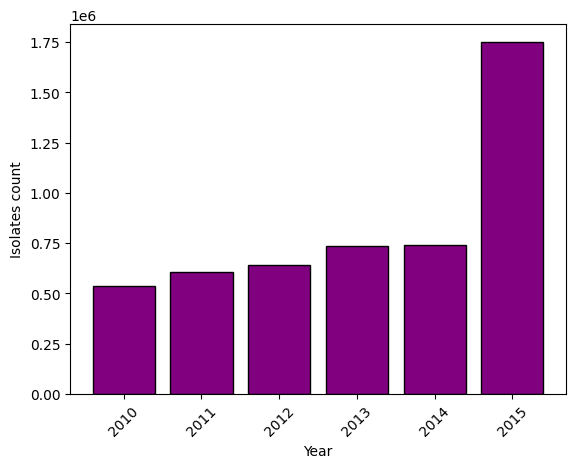

In [ ]:
from helpers.functions import get_N_per_year
from matplotlib import pyplot as plt
file_paths = [

    #2013
    
    #E-Coli
    r"data\raw\2013\E-Coli\number-3GCREC-percentage-ESBL-2013.xlsx",
    r"data\raw\2013\E-Coli\number-e-coli-isolates-and-percentage-combined-resistance-2010-2013.xlsx",
    r"data\raw\2013\E-Coli\number-e-coli-isolates-and-percentage-resistant-3-gen-cephalosporins-2010-2013.xlsx",
    r"data\raw\2013\E-Coli\number-e-coli-isolates-and-percentage-resistant-aminoglycosides-2010-2013.xlsx",
    r"data\raw\2013\E-Coli\number-e-coli-isolates-and-percentage-resistant-aminopenicilins-2010-2013.xlsx",
    r"data\raw\2013\E-Coli\number-e-coli-isolates-and-percentage-resistant-carbapenems-2010-2013.xlsx",
    r"data\raw\2013\E-Coli\number-e-coli-isolates-and-percentage-resistant-fluoroquinolones-2010-2013.xlsx",

    #Enterococci
    r"data\raw\2013\Enterococci\number-e-faecalis-isolates-and-percentage-high-level-resistance-aminoglycosides-2010-2013.xlsx",
    r"data\raw\2013\Enterococci\number-e-faecium-isolates-and-percentage-resistant-vancomycin-2010-2013.xlsx",

    #K-Pneumoniae
    r"data\raw\2013\K-Pneumoniae\number-3GCRKP-percentage-ESBL-2013.xlsx",
    r"data\raw\2013\K-Pneumoniae\number-k-pneumoniae-isolates-and-percentage-combined-resistance-2010-2013.xlsx",
    r"data\raw\2013\K-Pneumoniae\number-k-pneumoniae-isolates-and-percentage-resistant-3-gen-cephalosporins-2010-2013.xlsx",
    r"data\raw\2013\K-Pneumoniae\number-k-pneumoniae-isolates-and-percentage-resistant-aminoglycosides-2010-2013.xlsx",
    r"data\raw\2013\K-Pneumoniae\number-k-pneumoniae-isolates-and-percentage-resistant-carbapenems-2010-2013.xlsx",
    r"data\raw\2013\K-Pneumoniae\number-k-pneumoniae-isolates-and-percentage-resistant-fluoroquinolones-2010-2013.xlsx",

    #P-aeruginosa
    r"data\raw\2013\P-aeruginosa\number-p-aeruginosa-isolates-and-percentage-combined-resistance-2010-2013.xlsx",
    r"data\raw\2013\P-aeruginosa\number-p-aeruginosa-isolates-and-percentage-resistant-aminoglycosides-2010-2013.xlsx",
    r"data\raw\2013\P-aeruginosa\number-p-aeruginosa-isolates-and-percentage-resistant-carbapenems-2010-2013.xlsx",
    r"data\raw\2013\P-aeruginosa\number-p-aeruginosa-isolates-and-percentage-resistant-ceftazidime-2010-2013.xlsx",
    r"data\raw\2013\P-aeruginosa\number-p-aeruginosa-isolates-and-percentage-resistant-fluoroquinolones-2010-2013.xlsx",
    r"data\raw\2013\P-aeruginosa\number-p-aeruginosa-isolates-and-percentage-resistant-piperacillin-2010-2013.xlsx",

    #S-aureus
    r"data\raw\2013\S-aureus\number-s-aureus-isolates-and-percentage-resistant-meticilin-2010-2013.xlsx",

    #S-pneumoniae
    r"data\raw\2013\S-pneumoniae\number-s-pneumoniae-isolates-and-percentage-non-susceptible-macrolides-2010-2013.xlsx",
    r"data\raw\2013\S-pneumoniae\number-s-pneumoniae-isolates-and-percentage-non-susceptible-penicillin-2010-2013.xlsx",
    r"data\raw\2013\S-pneumoniae\number-s-pneumoniae-isolates-and-percentage-non-susceptible-penicillins-macrolides-2010-2013.xlsx",


       #2014
    
    #Acinetobacter
    r"data\raw\2014\Acinetobacter\acinetobacter-resistance-combinations-2014.xlsx",

    #E-Coli
    r"data\raw\2014\E-Coli\e-coli-resistance-combinations-2014.xlsx",
    r"data\raw\2014\E-Coli\number-3GCREC-percentage-ESBL-2014.xlsx",
    r"data\raw\2014\E-Coli\number-e-coli-isolates-and-percentage-combined-resistance-2011-2014.xlsx",
    r"data\raw\2014\E-Coli\number-e-coli-isolates-and-percentage-resistant-aminoglycosides-2011-2014.xlsx",
    r"data\raw\2014\E-Coli\number-e-coli-isolates-and-percentage-resistant-carbapenems-2011-2014.xlsx",
    r"data\raw\2014\E-Coli\number-e-coli-isolates-and-percentage-resistant-cephalosporins-2011-2014.xlsx",
    r"data\raw\2014\E-Coli\number-e-coli-isolates-and-percentage-resistant-fluoroquinolones-2011-2014.xlsx",

    #Enterococci
    r"data\raw\2014\Enterococci\number-e-faecalis-isolates-and-percentage-high-level-resistance-aminoglycosides-2011-2014.xlsx",
    r"data\raw\2014\Enterococci\number-e-faecium-isolates-and-percentage-resistant-vancomycin-2011-2014.xlsx",

    #K-Pneumoniae
    r"data\raw\2014\K-pneumoniae\k-pneumoniae-resistance-combinations-2014.xlsx",
    r"data\raw\2014\K-pneumoniae\number-3GCRKP-percentage-ESBL-2014.xlsx",
    r"data\raw\2014\K-pneumoniae\number-k-pneumoniae-isolates-and-percentage-combined-resistance-2011-2014.xlsx",
    r"data\raw\2014\K-pneumoniae\number-k-pneumoniae-isolates-and-percentage-resistant-carbapenems-2011-2014.xlsx",
    r"data\raw\2014\K-pneumoniae\number-k-pneumoniae-isolates-and-percentage-resistant-cephalosporins-2011-2014.xlsx",
    r"data\raw\2014\K-pneumoniae\number-k-pneumoniae-isolates-and-percentage-resistant-fluoroquinolones-2011-2014.xlsx",

    #P-aeruginosa
    r"data\raw\2014\P-aeruginosa\number-p-aeruginosa-isolates-and-percentage-combined-resistance-2011-2014.xlsx",
    r"data\raw\2014\P-aeruginosa\number-p-aeruginosa-isolates-and-percentage-resistant-aminoglycosides-2011-2014.xlsx",
    r"data\raw\2014\P-aeruginosa\number-p-aeruginosa-isolates-and-percentage-resistant-carbapenems-2011-2014.xlsx",
    r"data\raw\2014\P-aeruginosa\number-p-aeruginosa-isolates-and-percentage-resistant-ceftazidime-2011-2014.xlsx",
    r"data\raw\2014\P-aeruginosa\number-p-aeruginosa-isolates-and-percentage-resistant-fluoroquinolones-2011-2014.xlsx",
    r"data\raw\2014\P-aeruginosa\number-p-aeruginosa-isolates-and-percentage-resistant-piperacillin-2011-2014.xlsx",
    r"data\raw\2014\P-aeruginosa\p-aeruginosa-resistance-combinations-2014.xlsx",

    #S-aureus
    r"data\raw\2014\S-aureus\number-s-aureus-isolates-and-percentage-resistant-meticilin-2011-2014.xlsx",

    #S-pneumoniae
    r"data\raw\2014\S-pneumoniae\number-s-pneumoniae-isolates-and-percentage-non-susceptible-macrolides-2011-2014.xlsx",
    r"data\raw\2014\S-pneumoniae\number-s-pneumoniae-isolates-and-percentage-non-susceptible-penicillin-2011-2014.xlsx",
    r"data\raw\2014\S-pneumoniae\number-s-pneumoniae-isolates-and-percentage-non-susceptible-penicillins-macrolides-2011-2014.xlsx",


    #2015

    #Acinetobacter
    r"data\raw\2015\Acinetobacter, Tables 3-21 to 3-25.xlsx",

    #E-Coli
    r"data\raw\2015\E-coli, Tables 3-1 to 3-7.xlsx",

    #Enterococci
    r"data\raw\2015\Enterococci, Tables 3-30 and 3-31.xlsx",

    #K-Pneumoniae
    r"data\raw\2015\Klebsiella, Tables 3-8 to 3-13.xlsx",

    #P-aeruginosa
    r"data\raw\2015\Pseudomonas, Tables 3-14 to 3-20.xlsx",

    #S-aureus
    r"data\raw\2015\Staphylococcus, Table 3-29.xlsx",

    #S-pneumoniae
    r"data\raw\2015\Streptococcus, Tables 3-26 to 3-28.xlsx",
]

sum_per_year = get_N_per_year(file_paths)

plt.style.use('seaborn-v0_8-pastel')
plt.bar(sum_per_year.keys(), sum_per_year.values(), color='purple', edgecolor='black')

plt.xlabel("Year")
plt.ylabel("Isolates count")
plt.xticks(rotation=45)
plt.show()


<h2 id="correlations-and-simple-dependencies">Correlations and Simple Dependencies</h2>

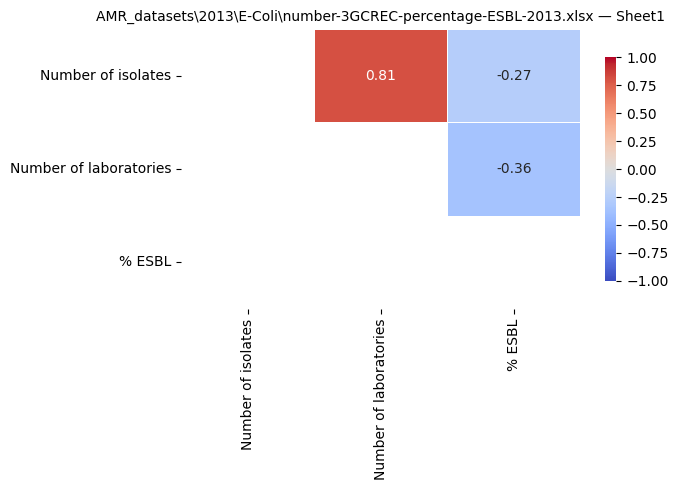

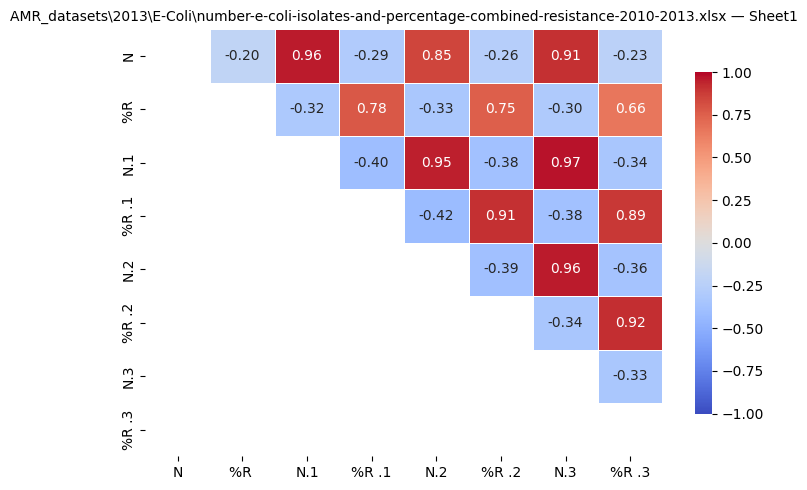

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


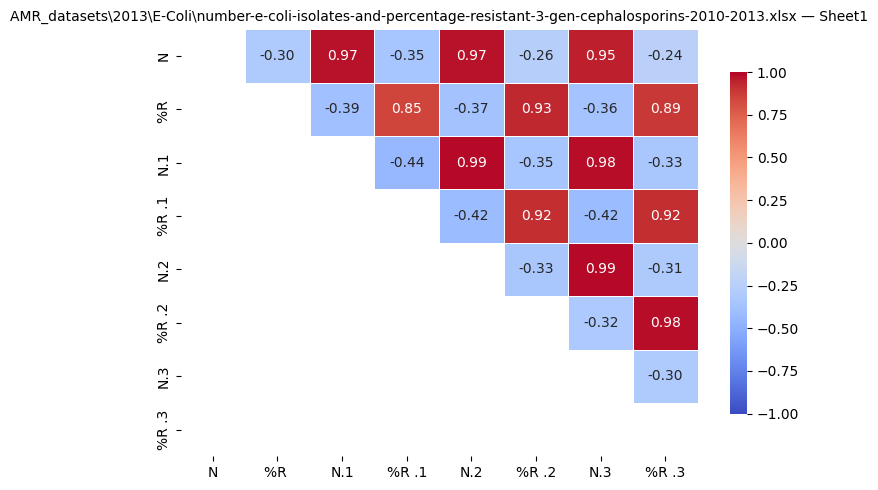

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


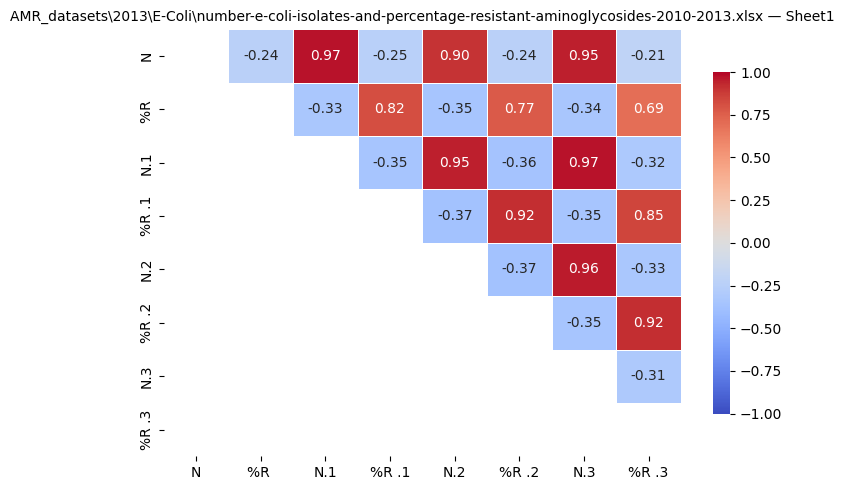

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


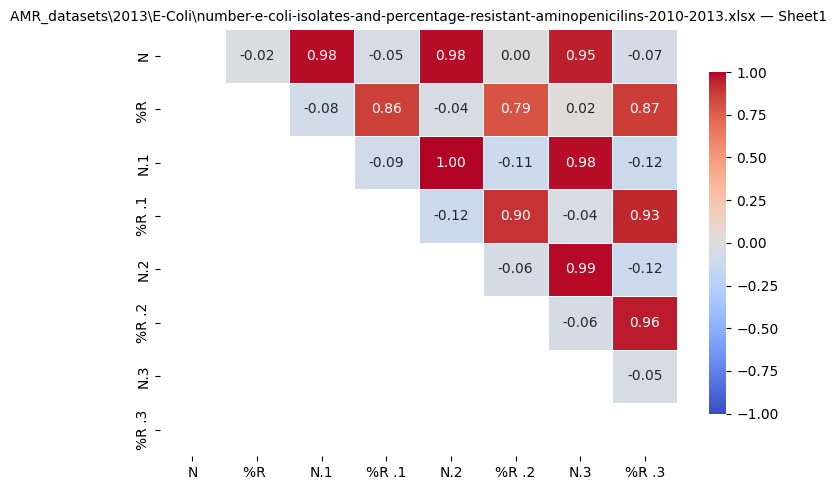

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


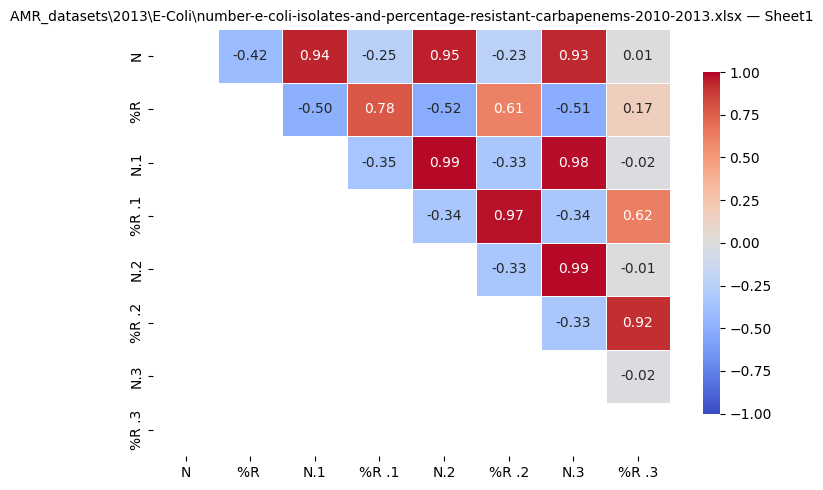

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


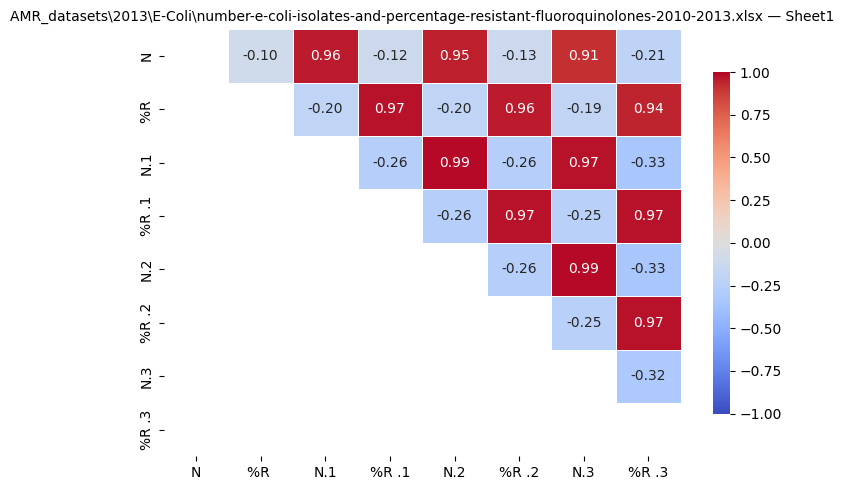

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Program

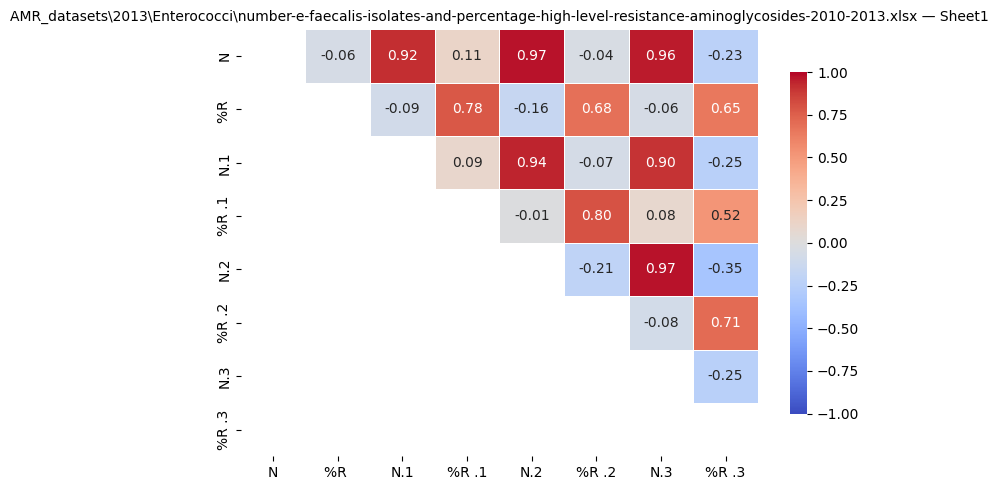

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Program

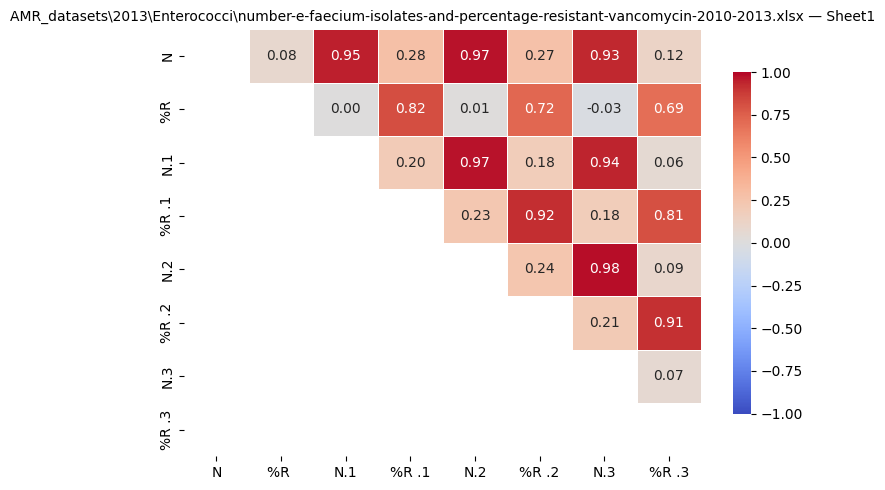

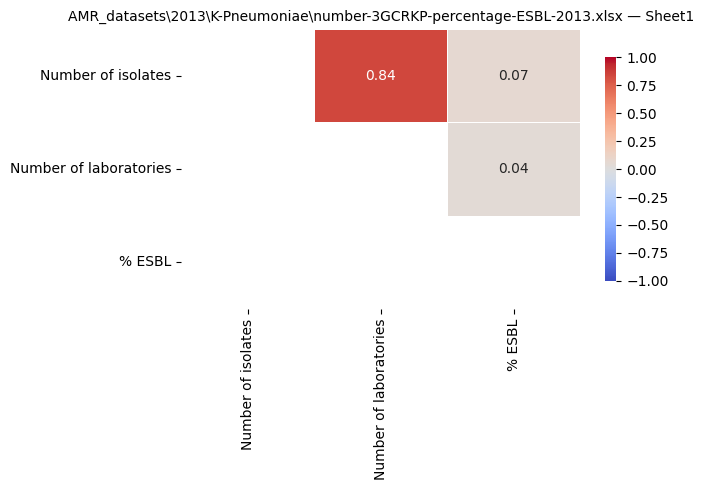

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


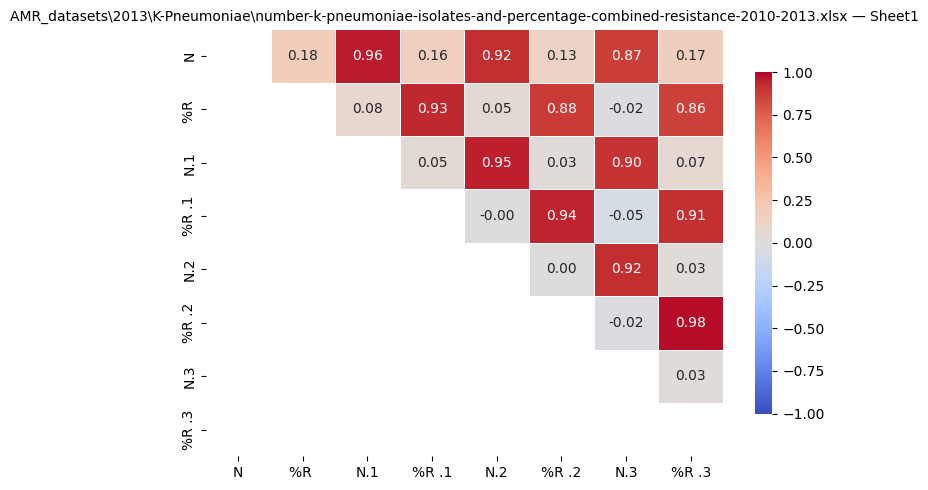

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


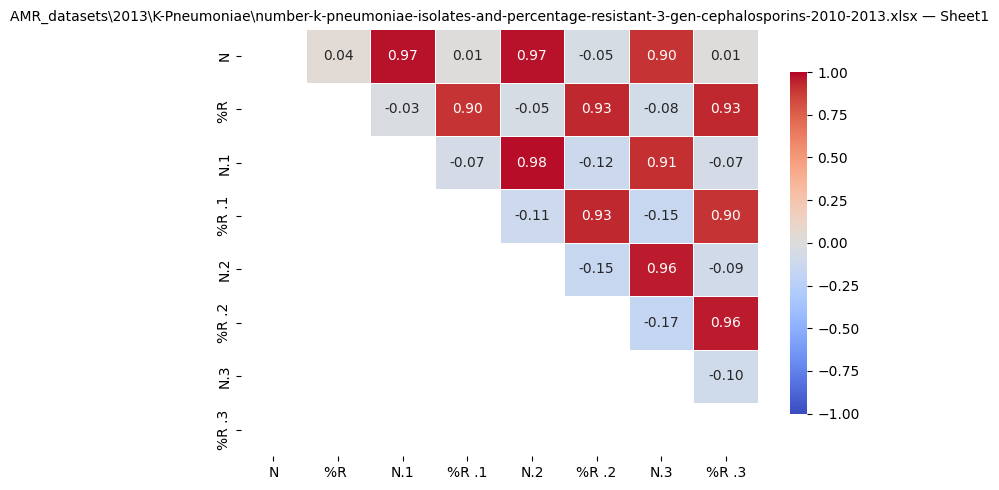

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


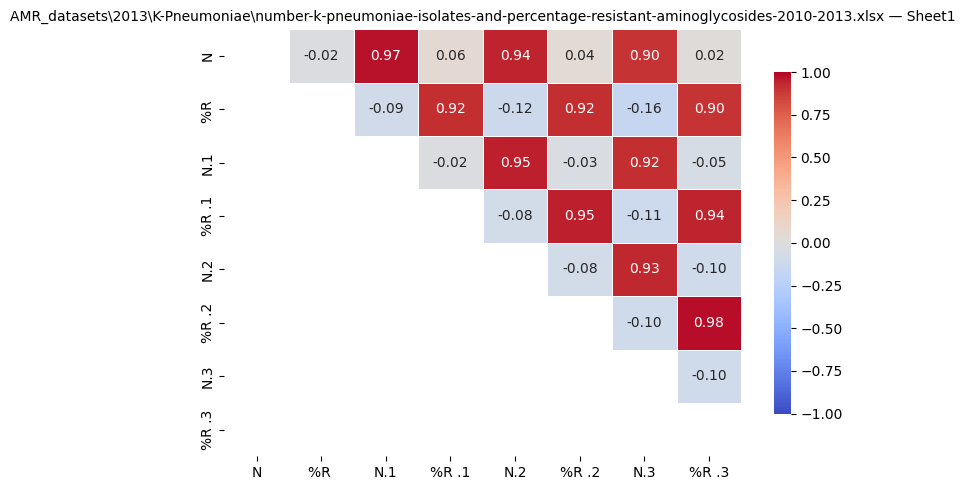

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


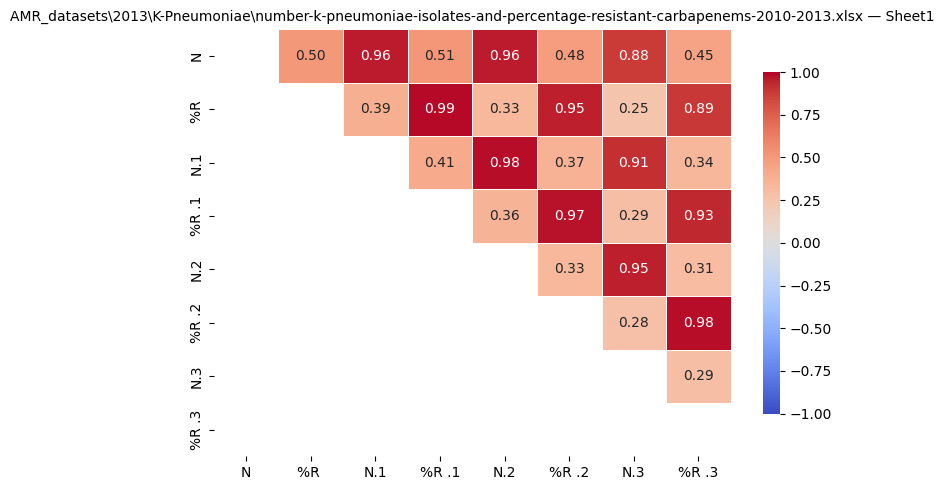

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


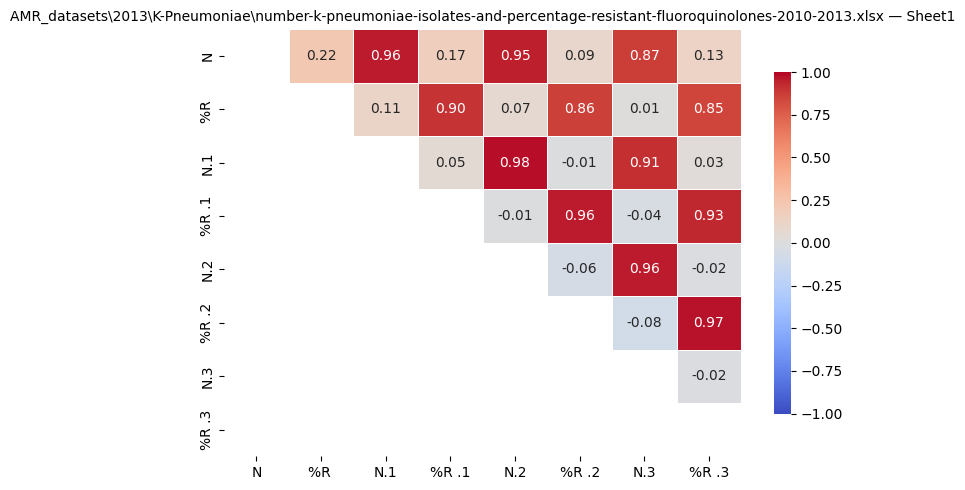

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Program

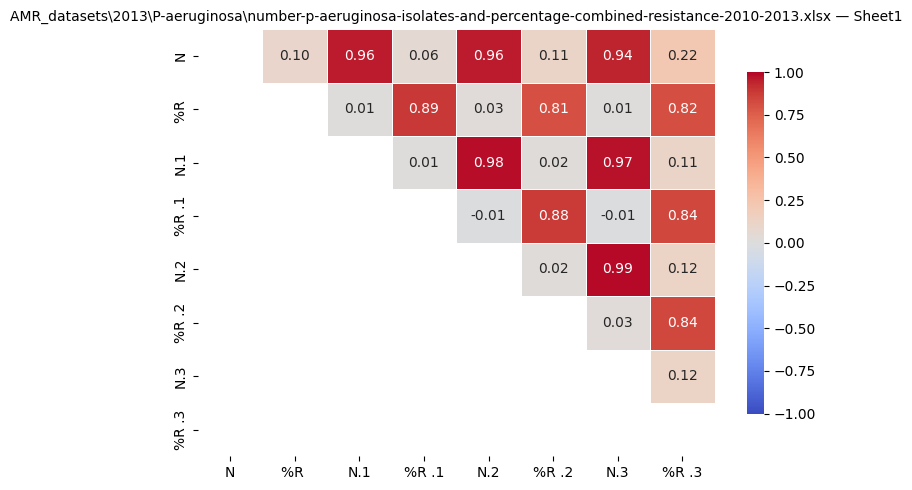

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Program

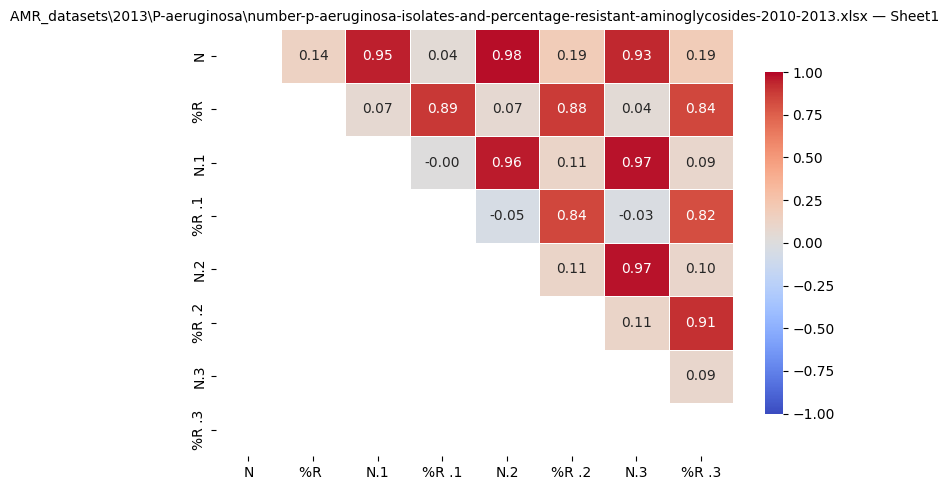

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Program

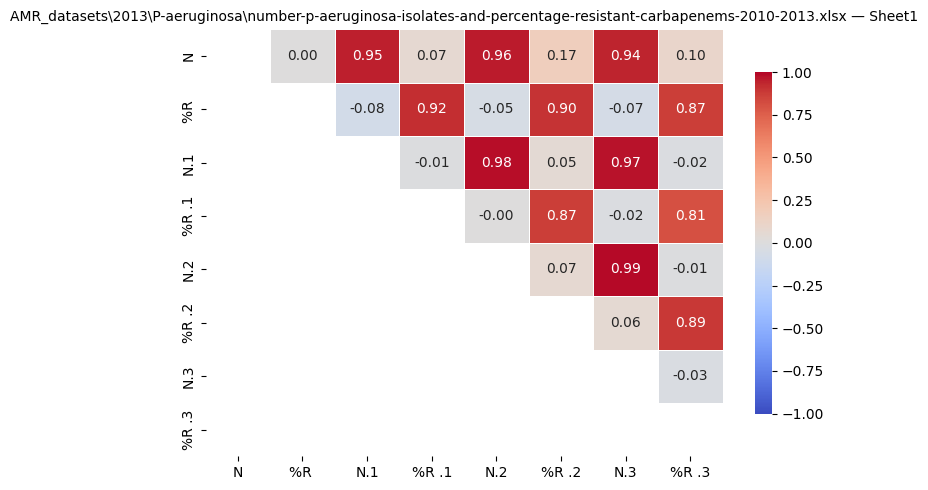

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Program

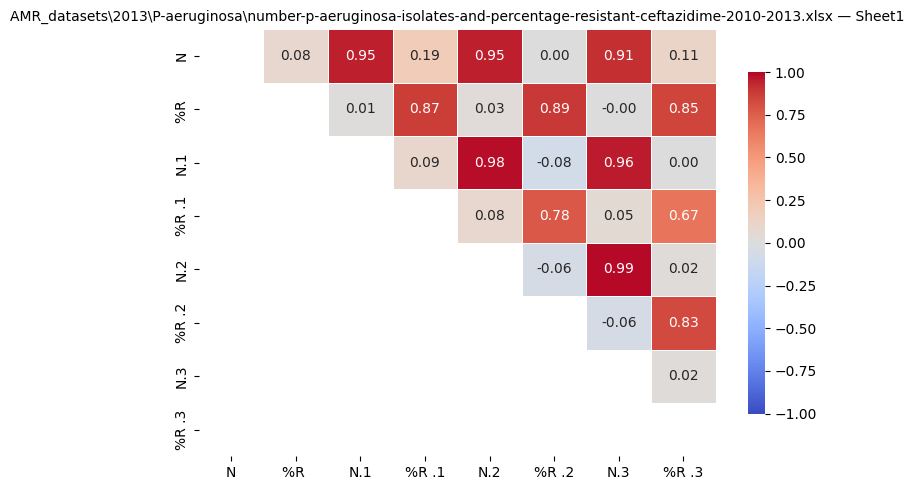

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Program

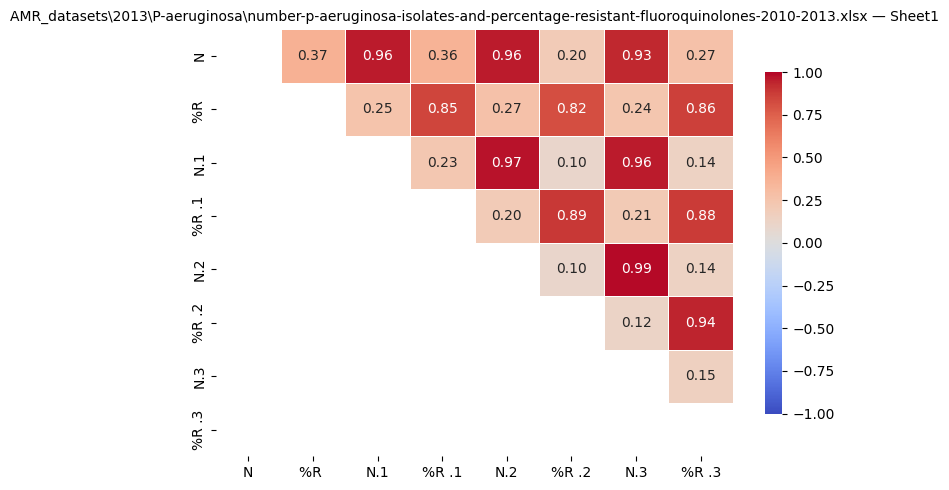

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Program

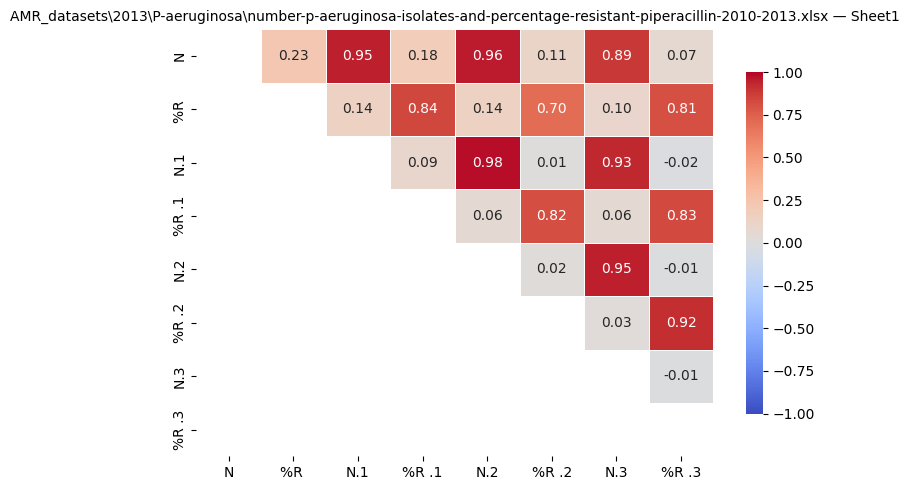

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Program

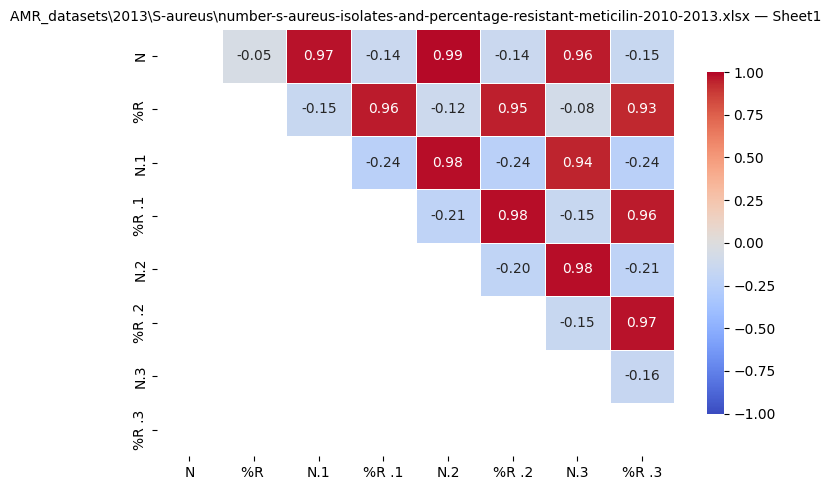

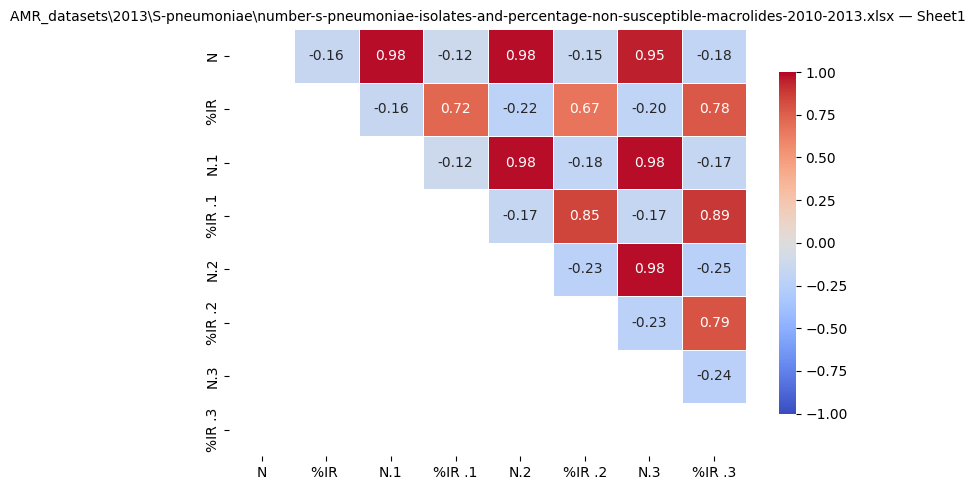

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Program

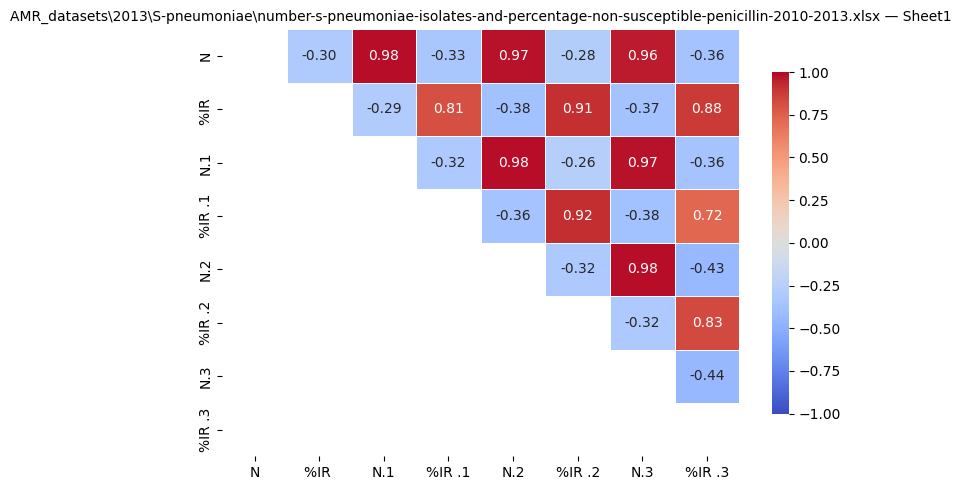

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Program

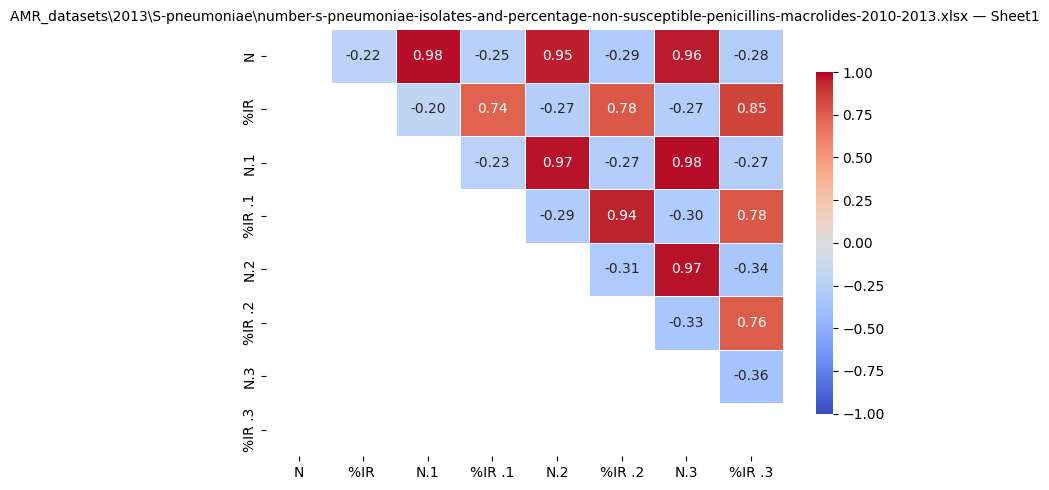

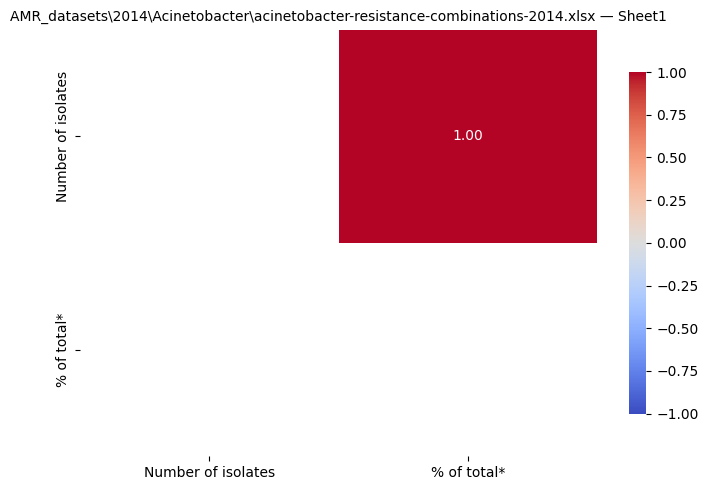

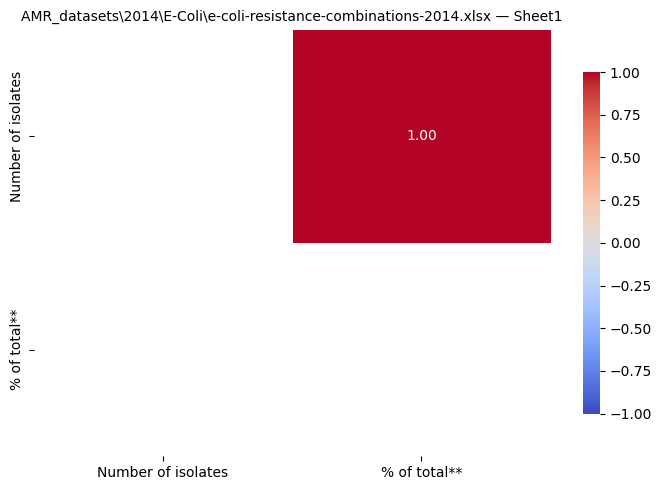

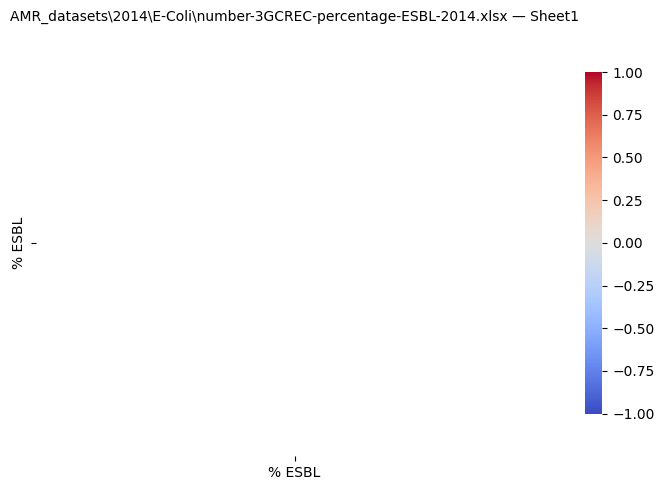

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


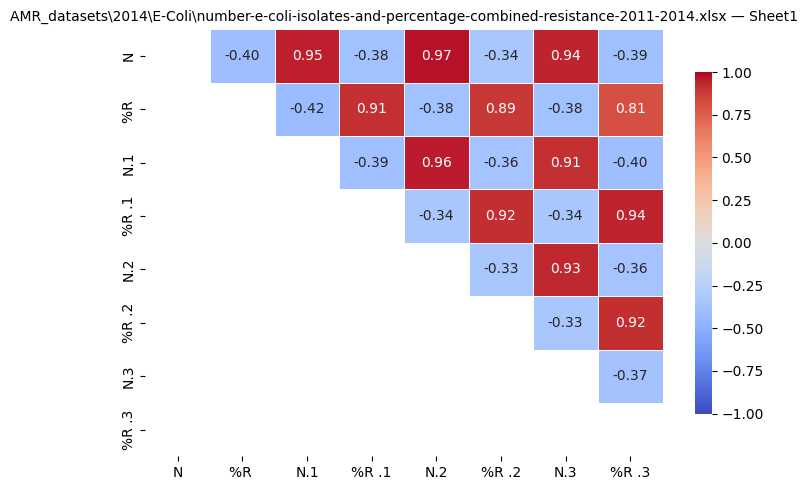

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


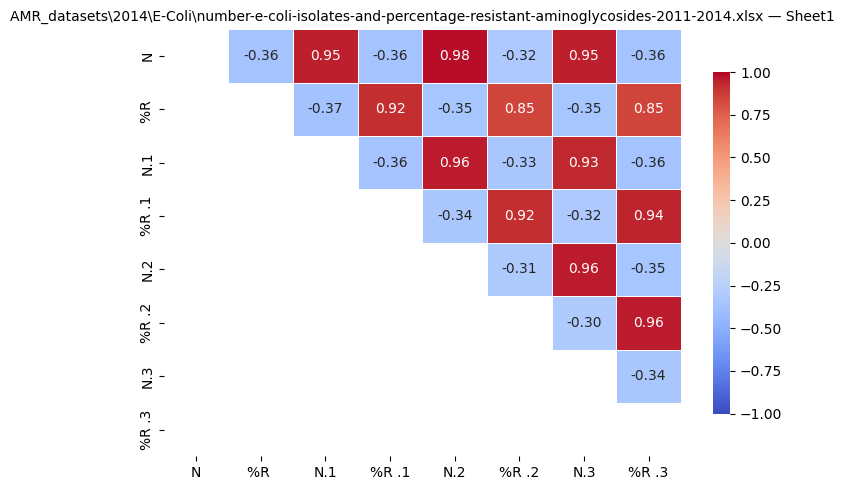

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


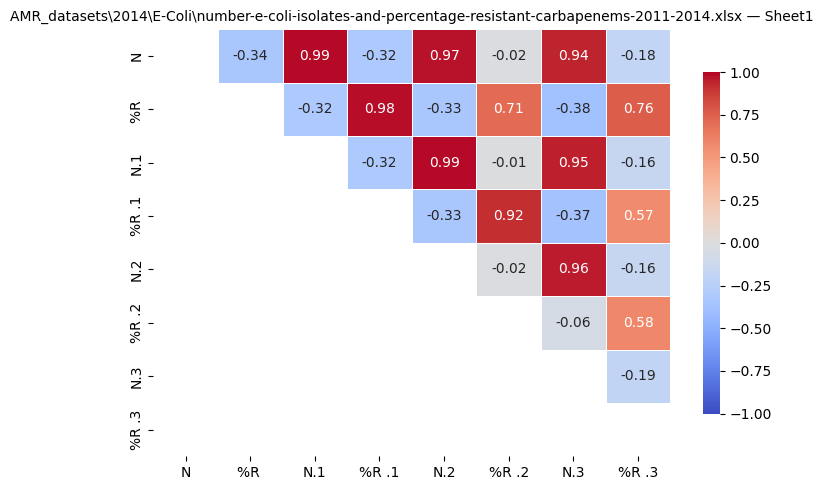

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


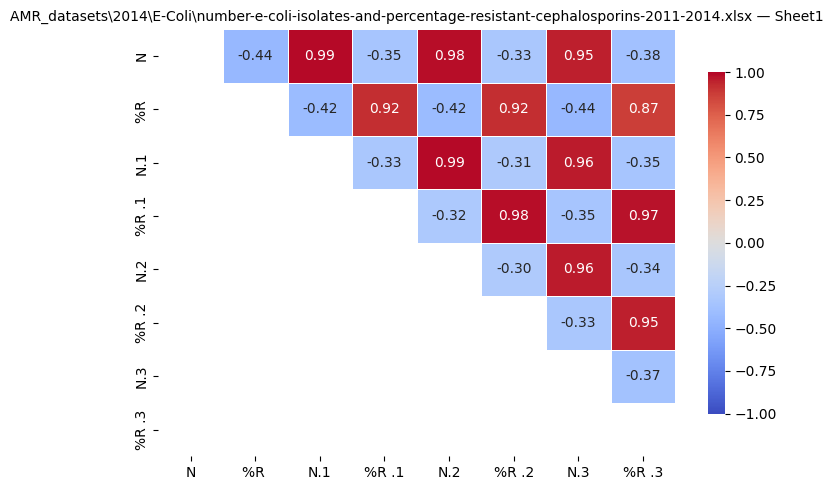

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


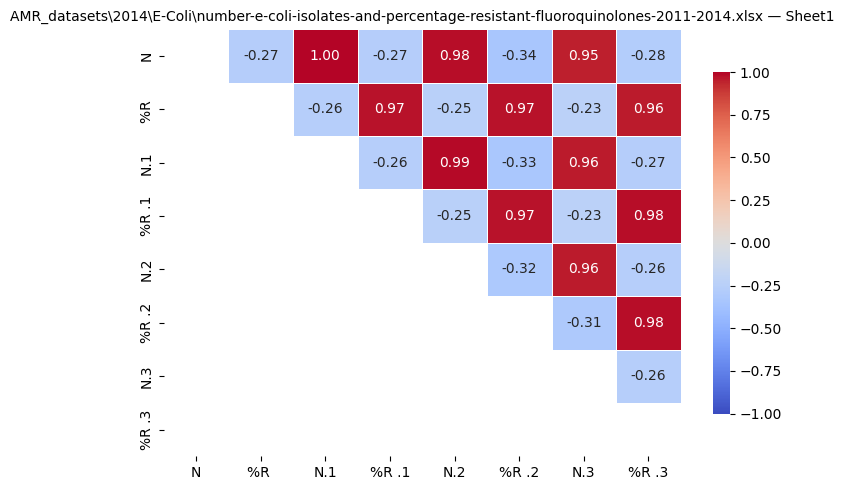

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Program

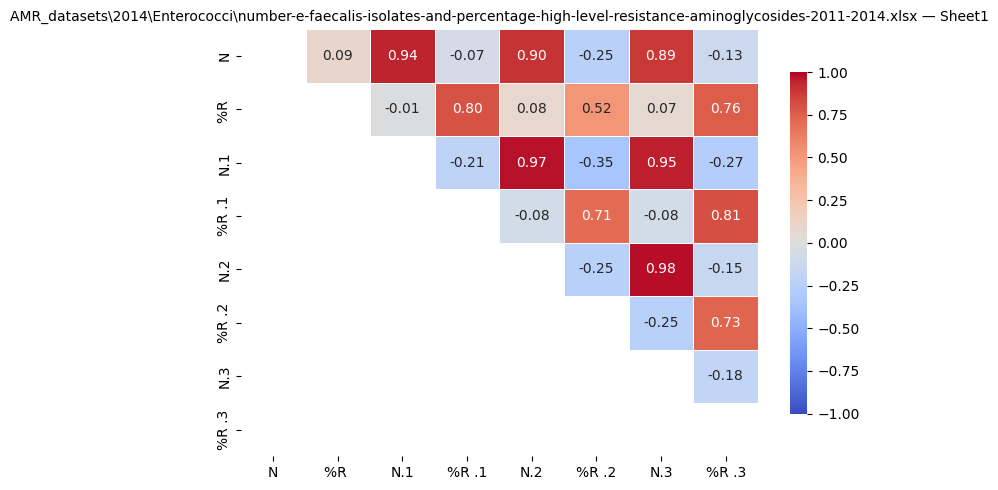

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Program

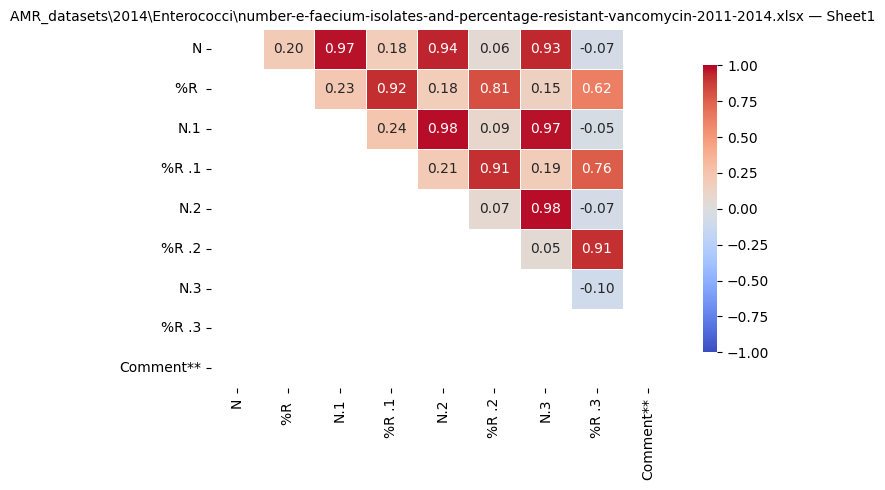

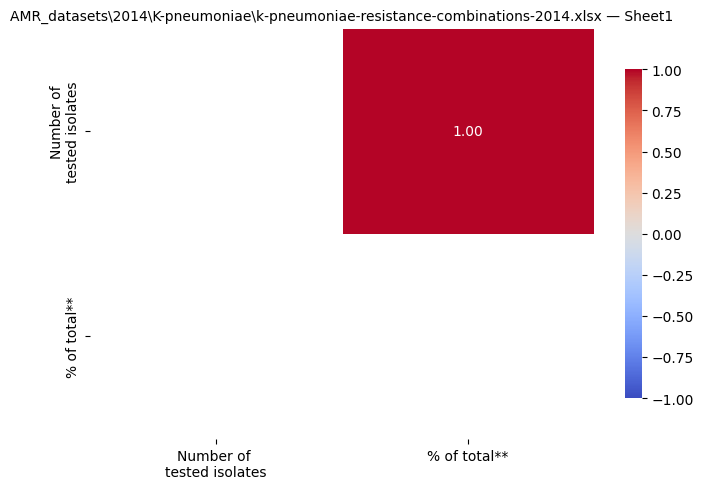

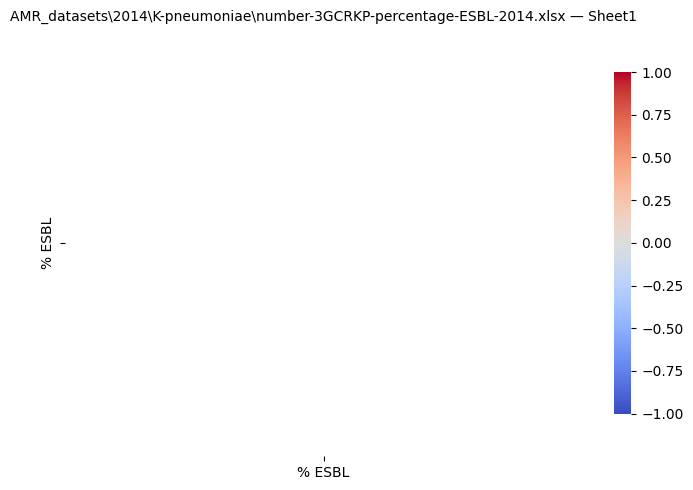

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


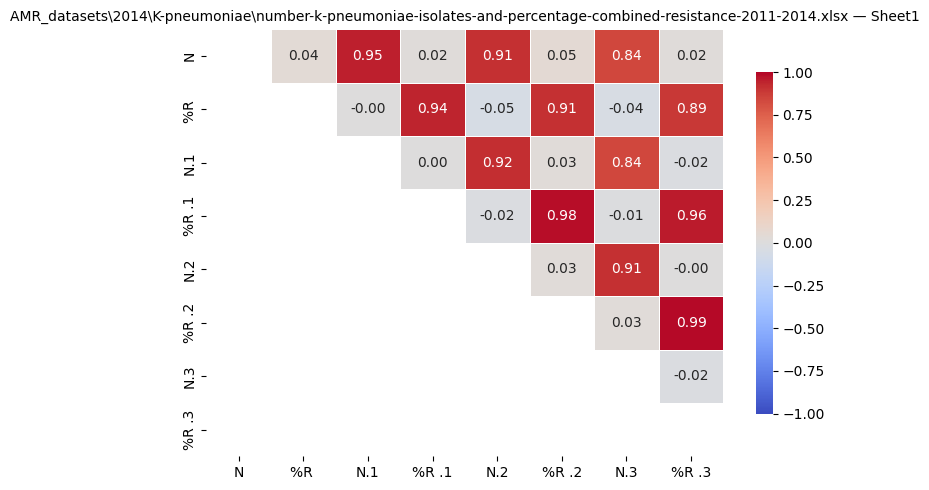

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Program

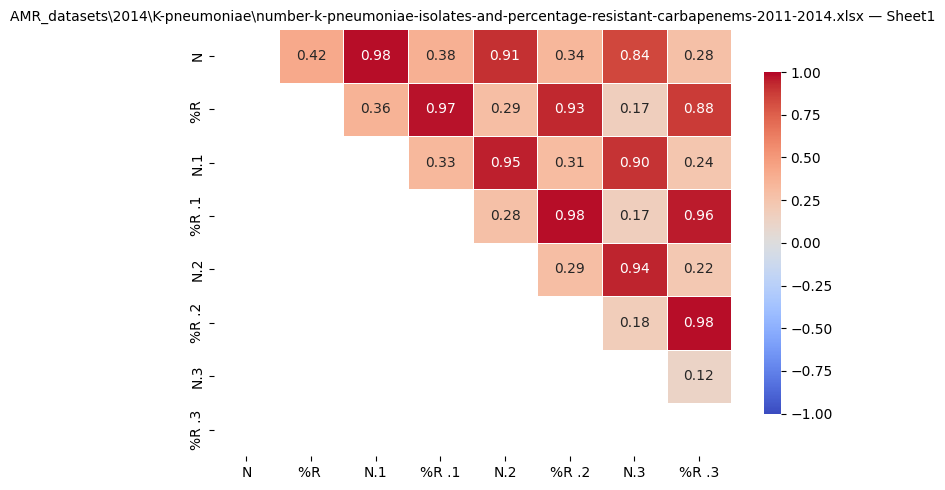

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


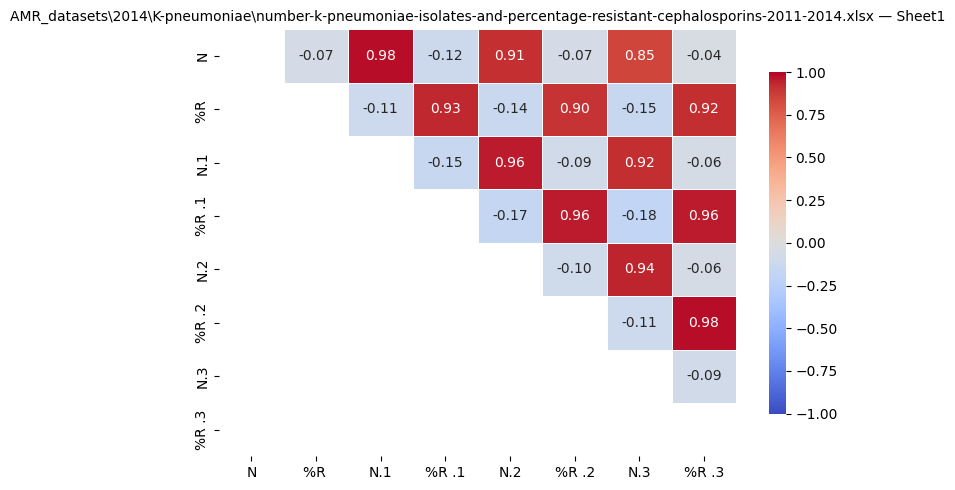

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


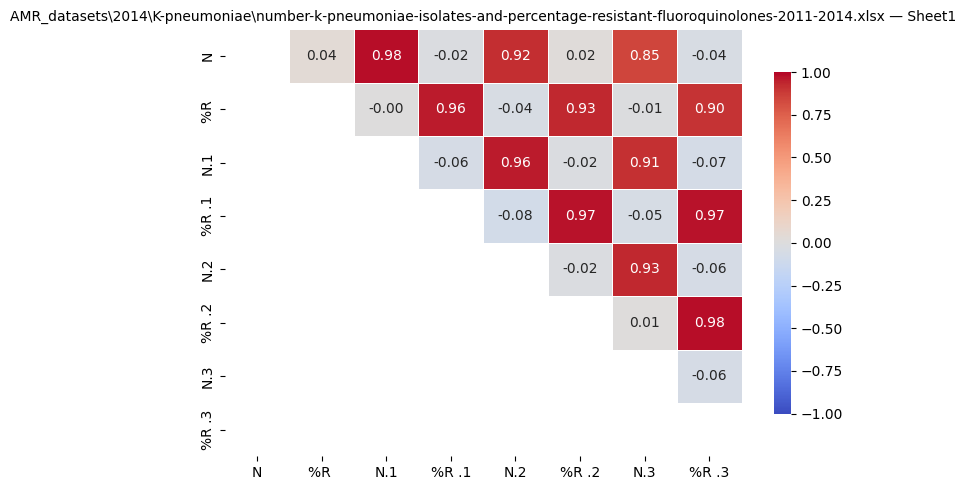

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Sparkline Group extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local

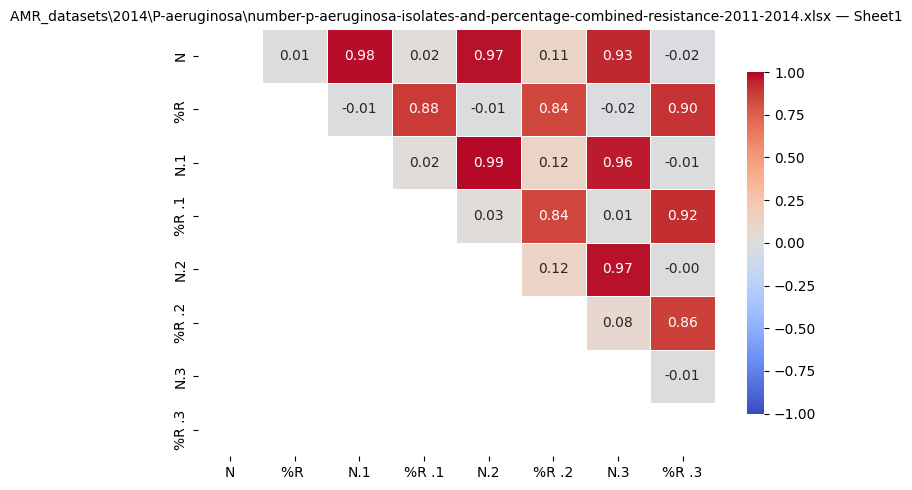

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Program

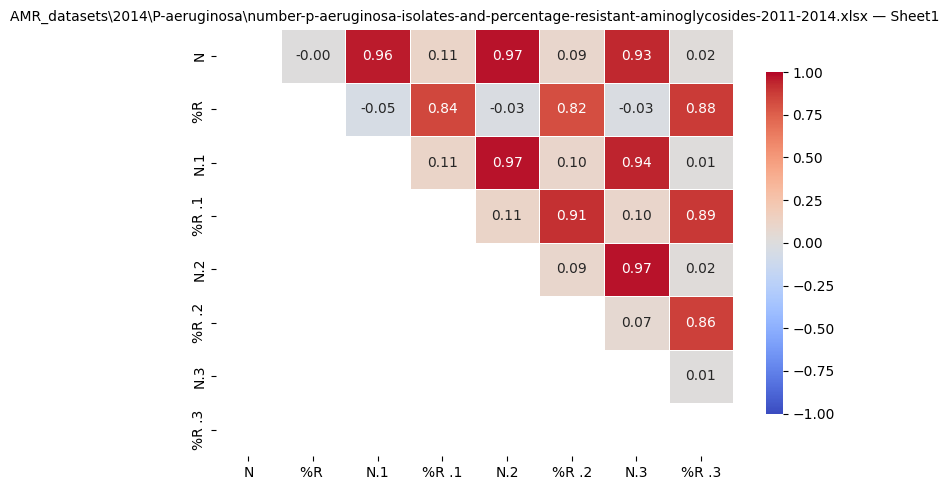

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Program

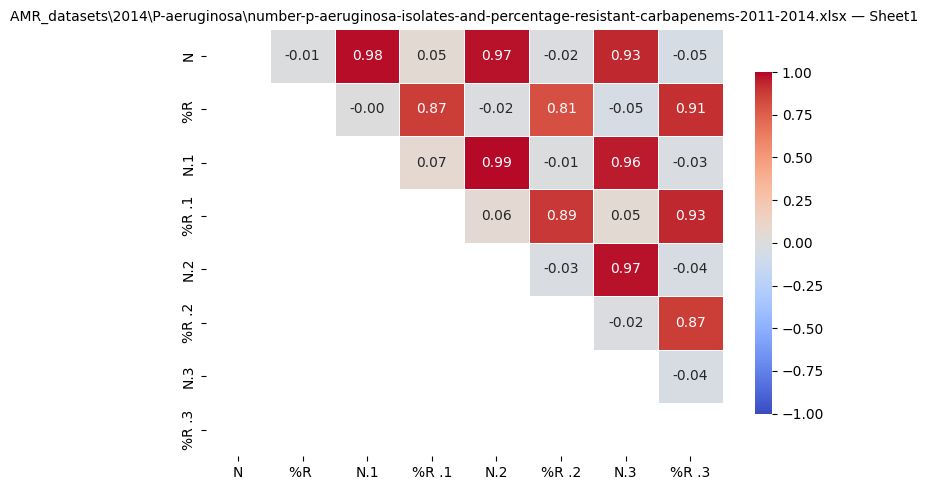

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Program

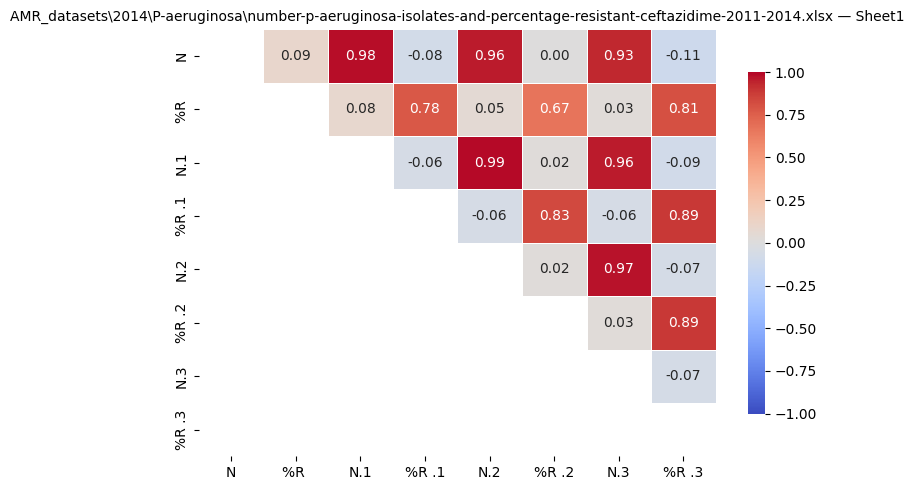

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Program

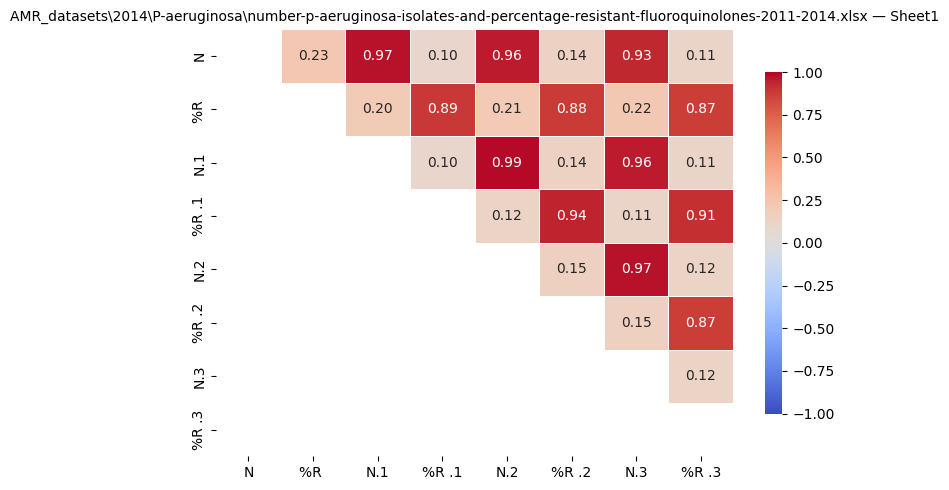

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Program

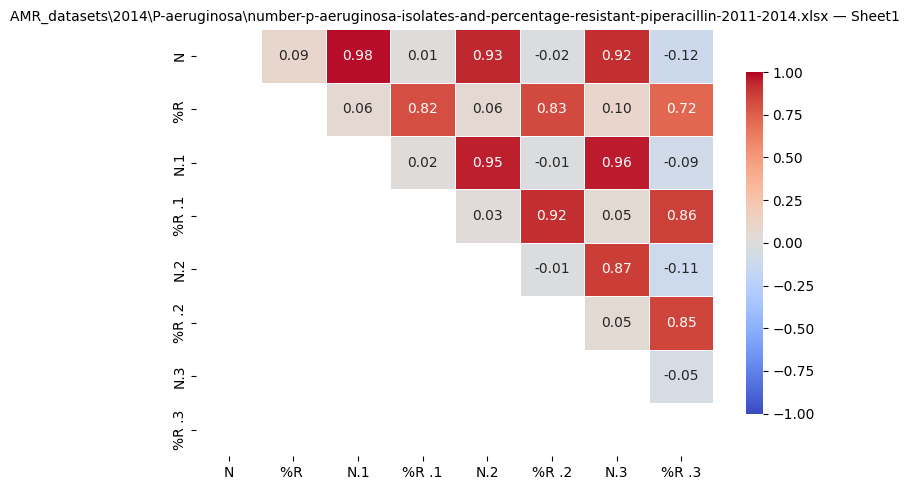

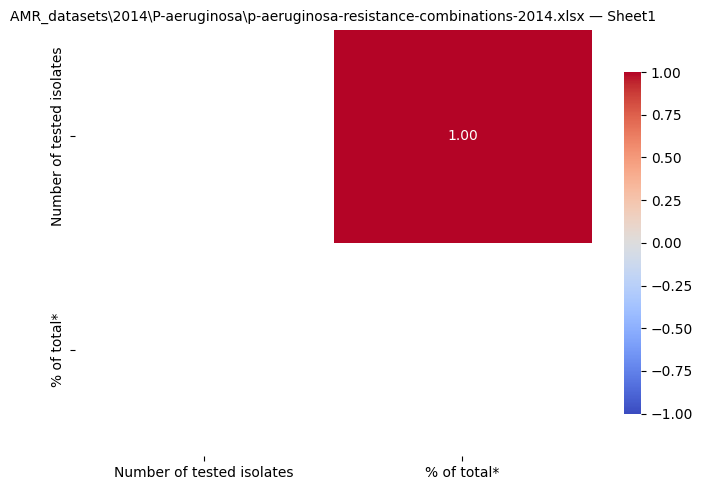

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


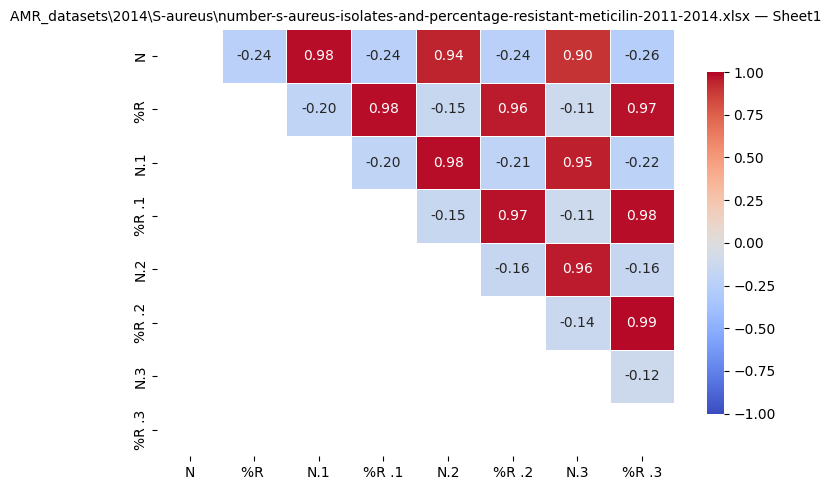

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Program

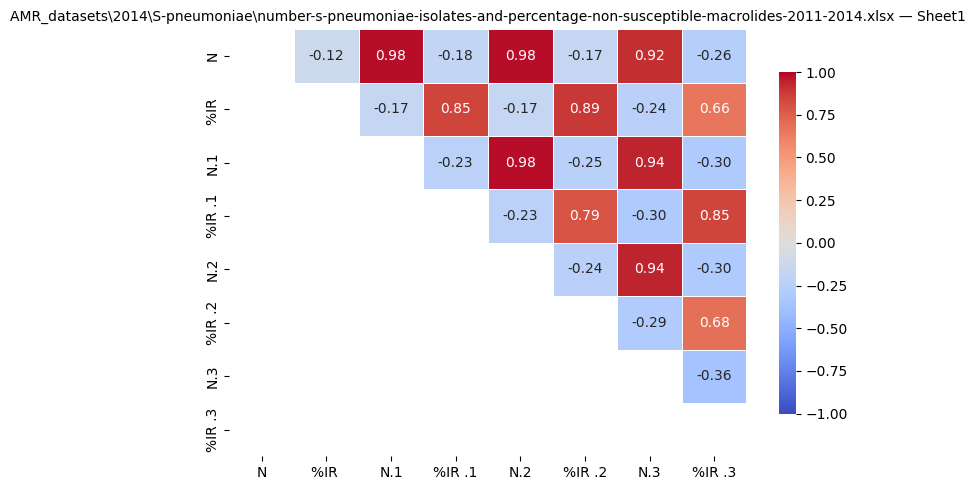

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Program

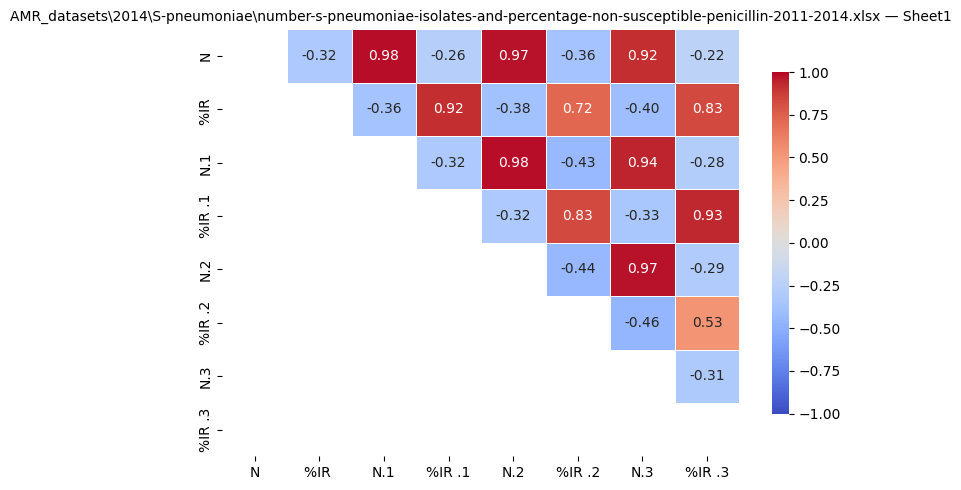

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\user\AppData\Local\Program

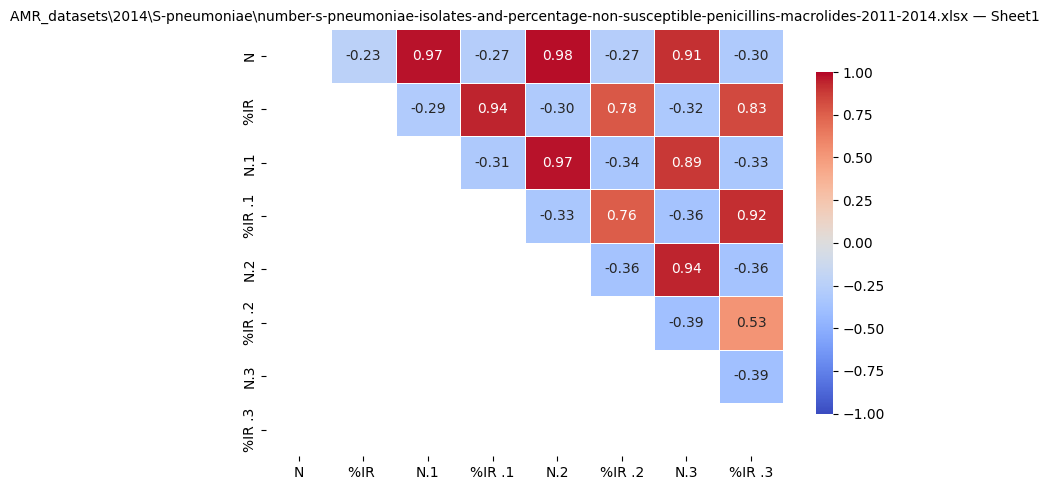

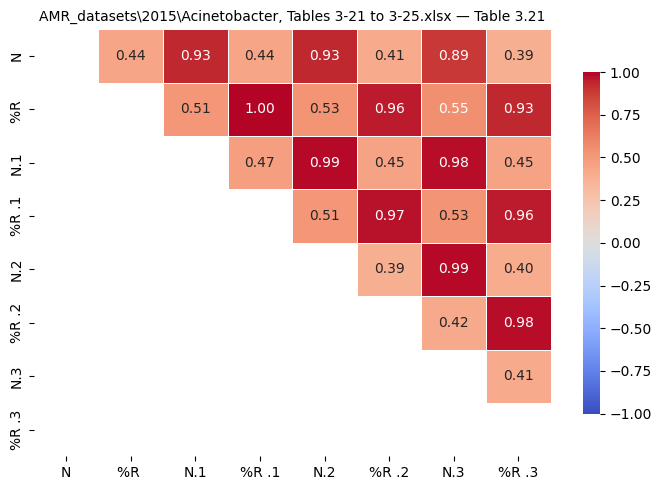

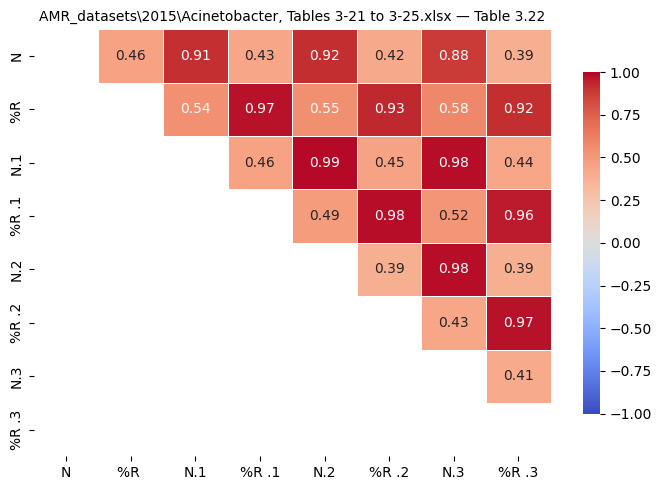

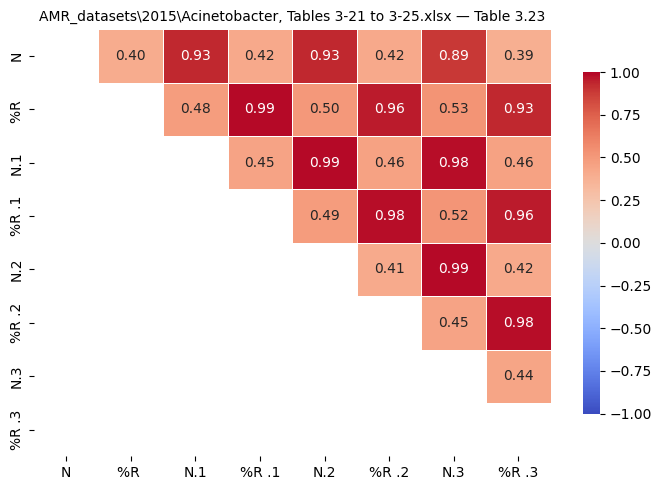

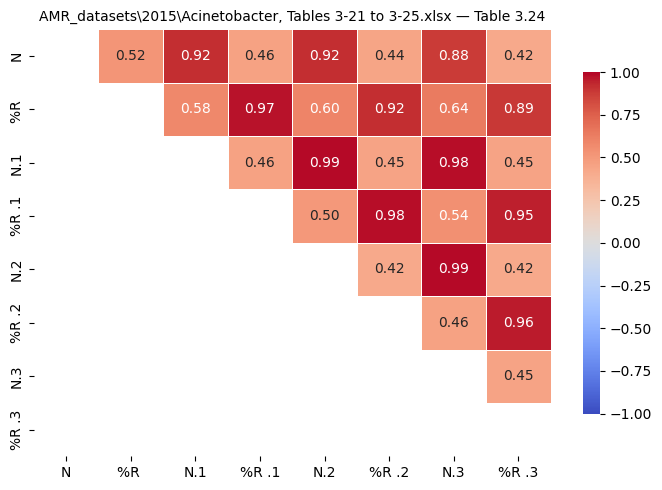

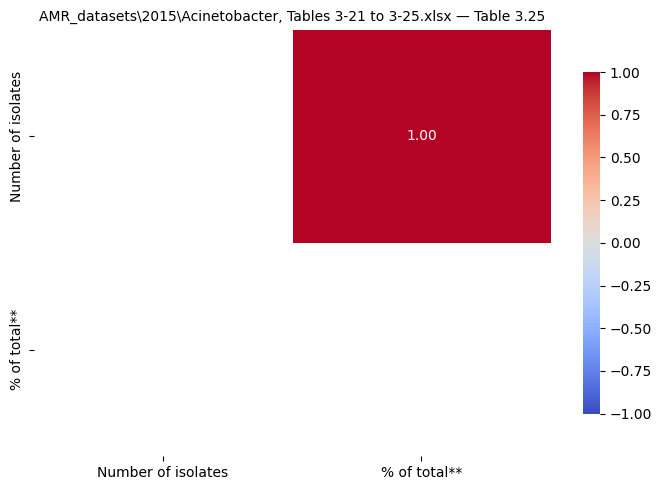

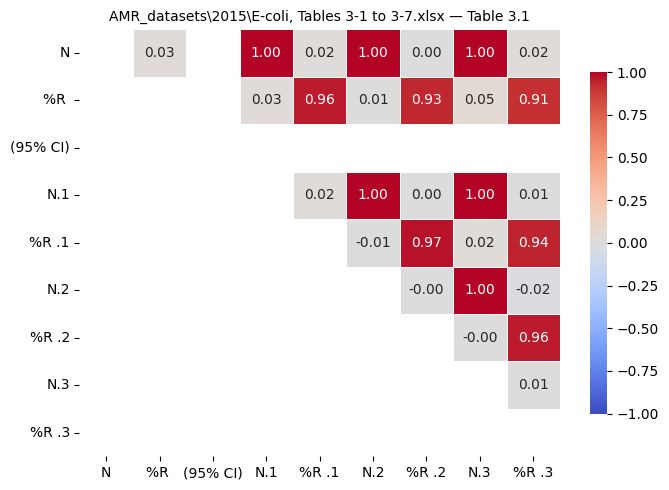

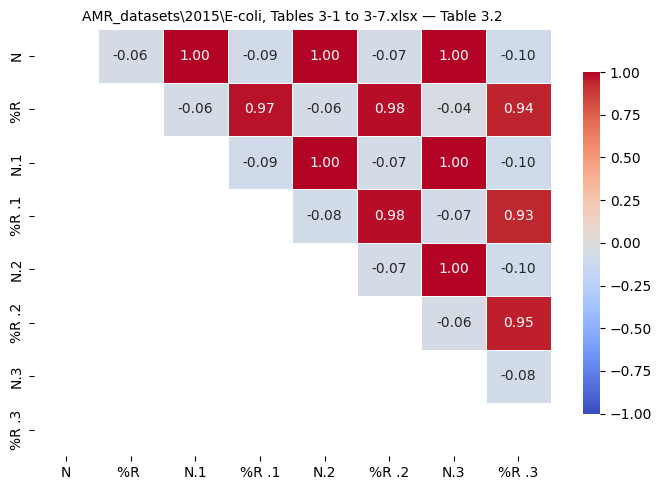

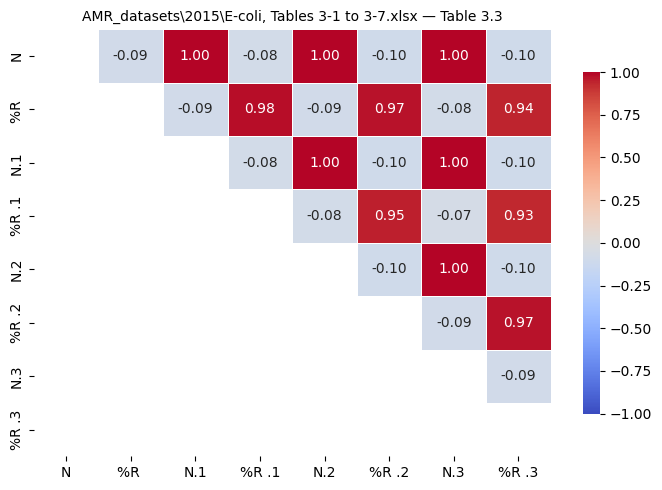

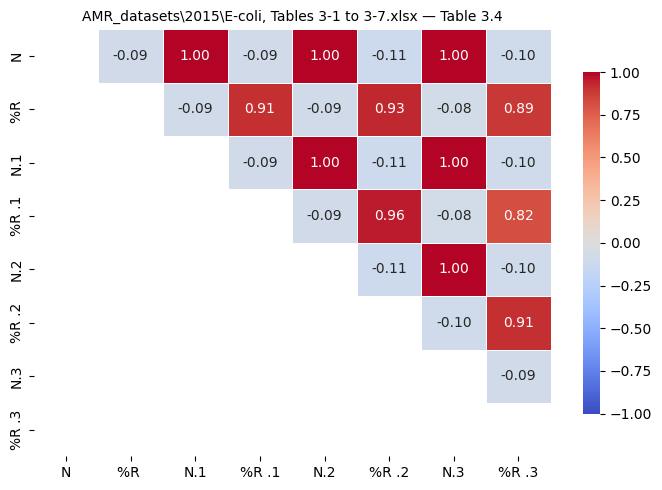

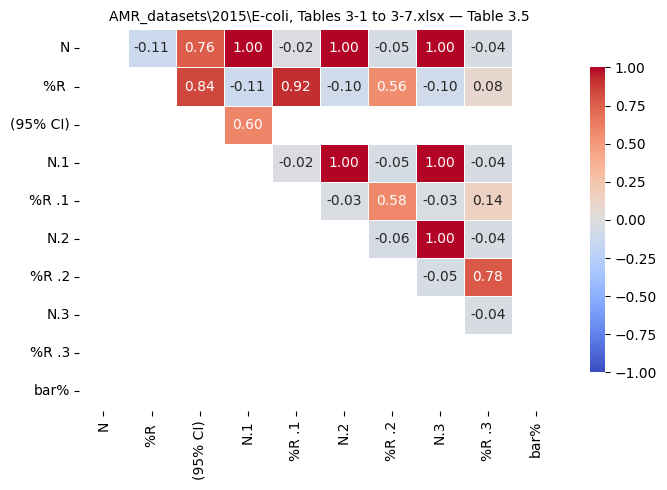

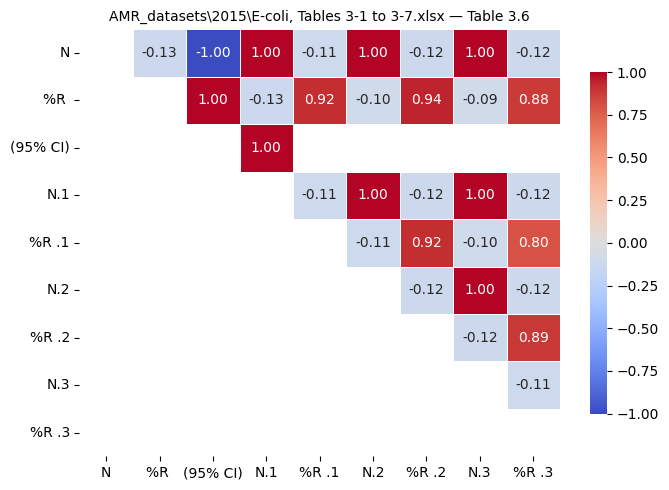

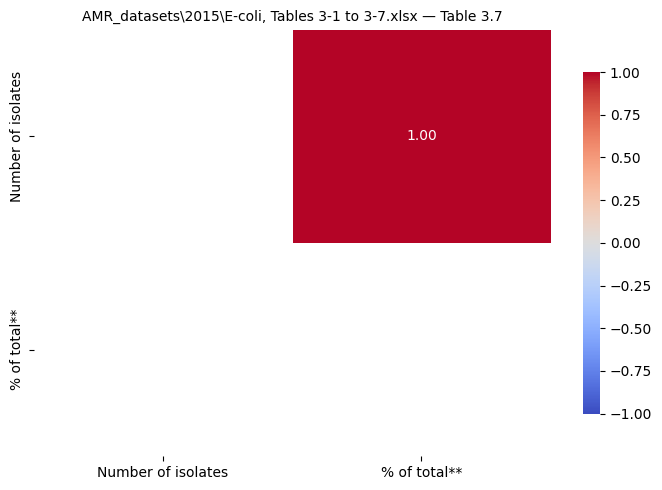

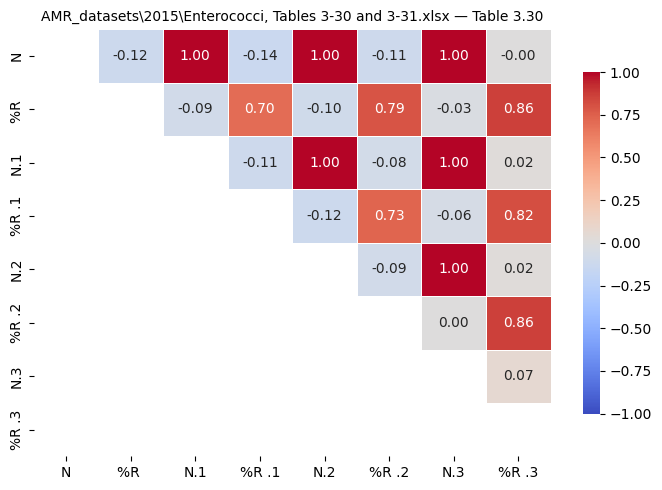

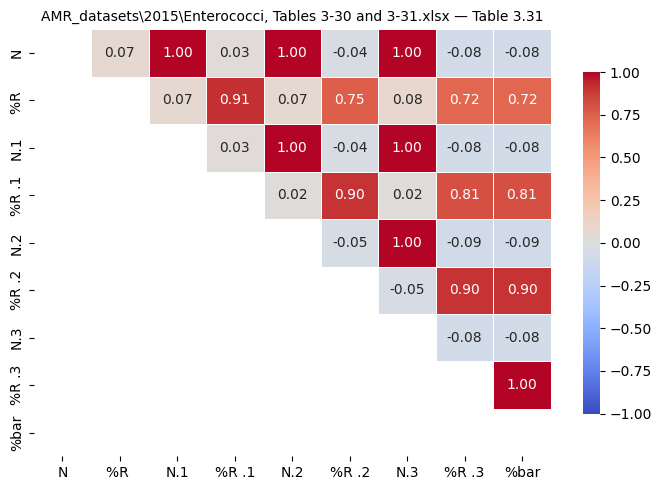

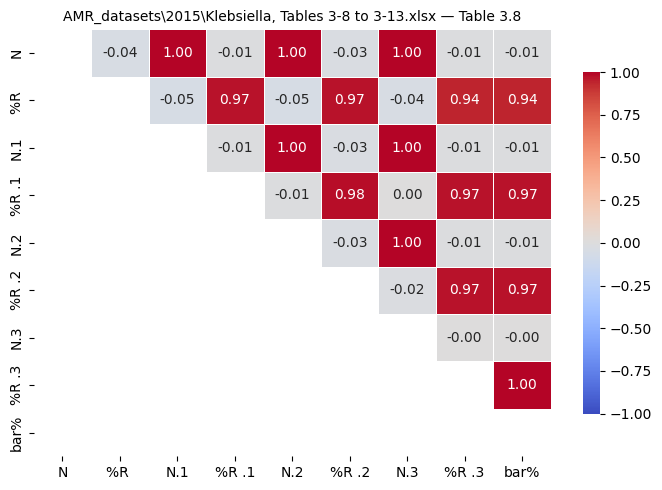

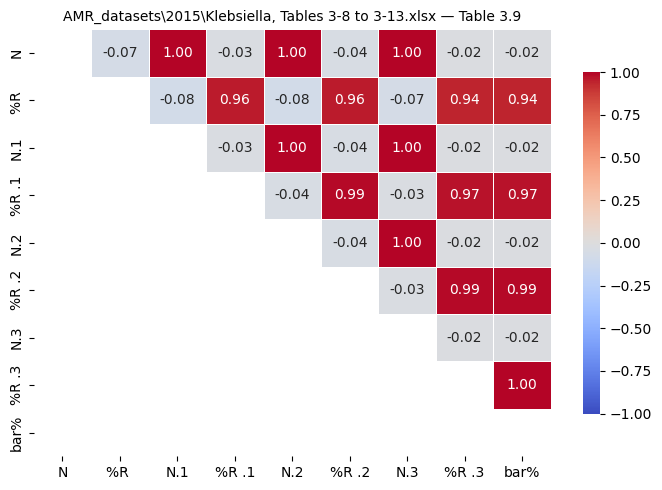

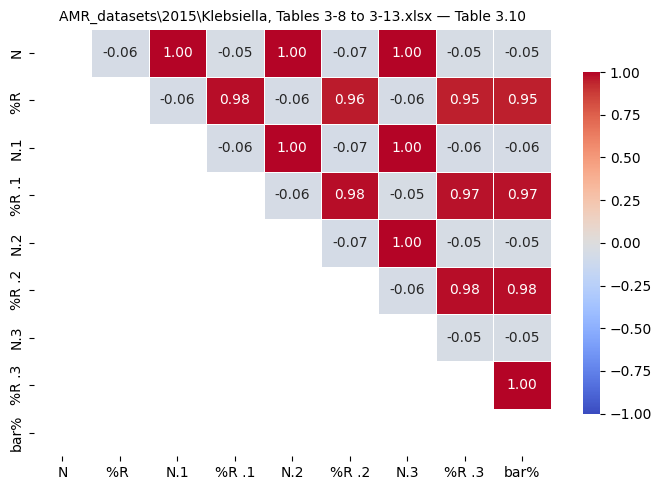

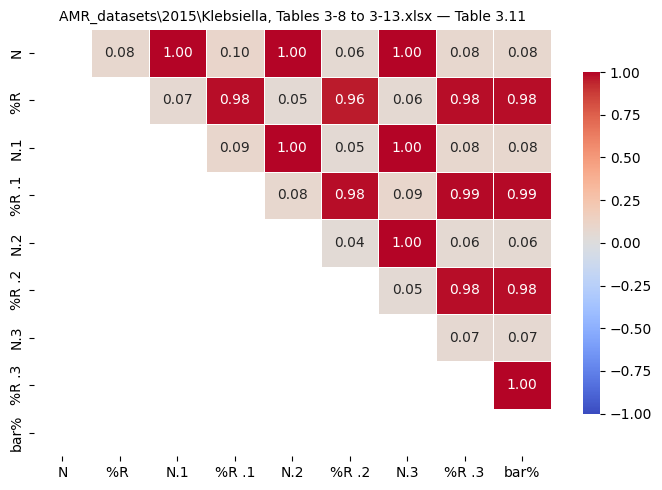

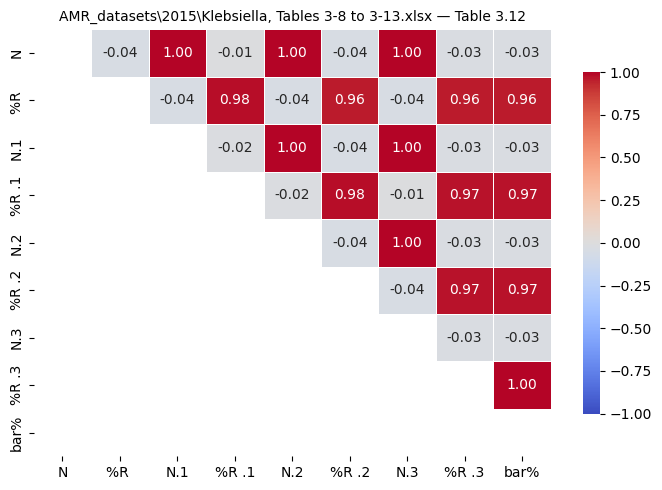

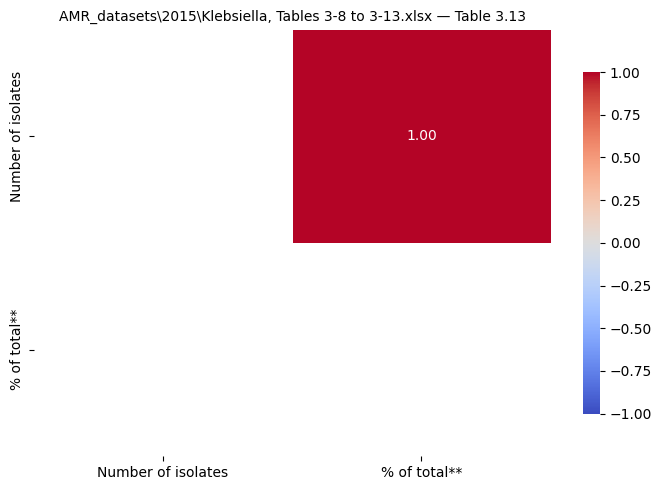

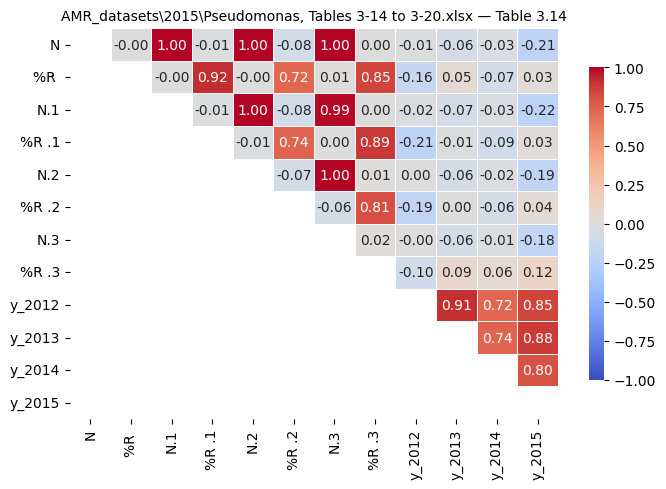

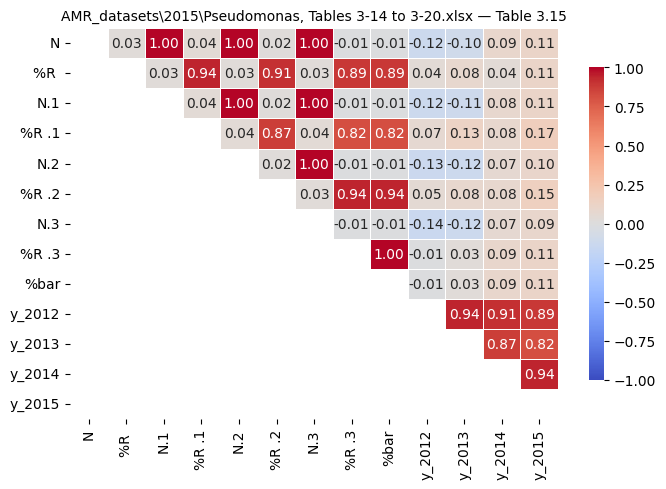

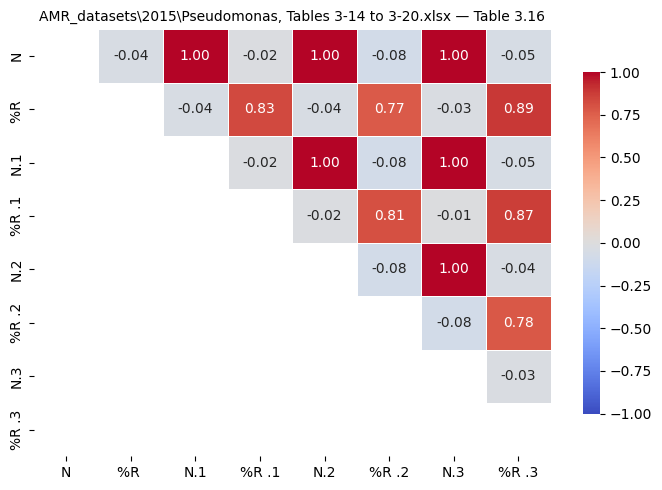

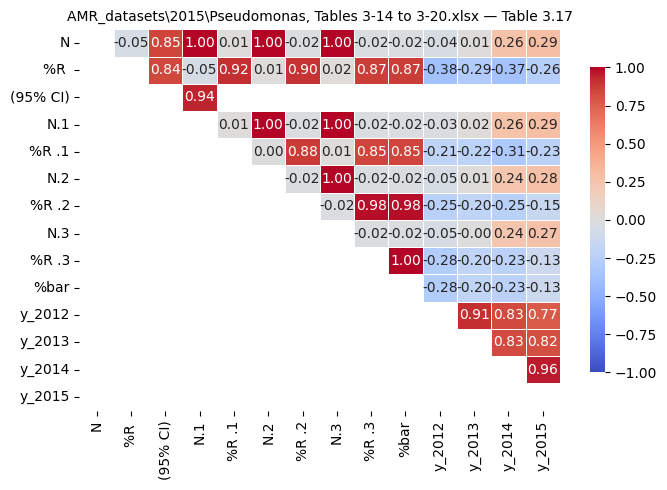

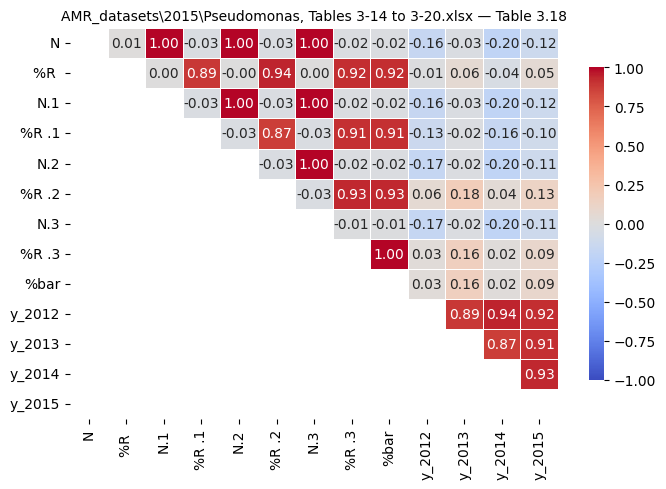

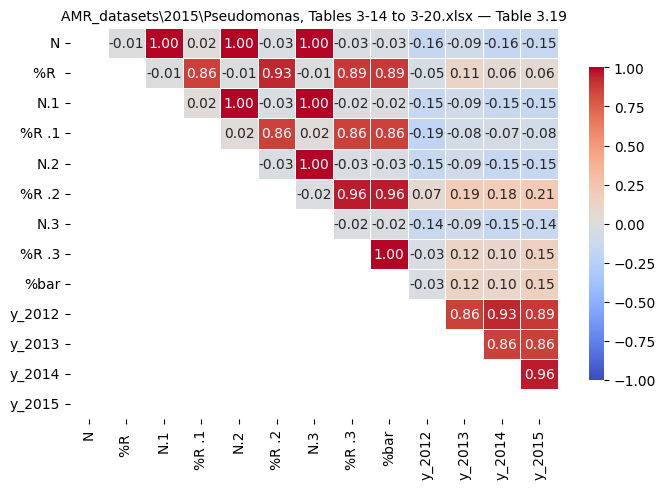

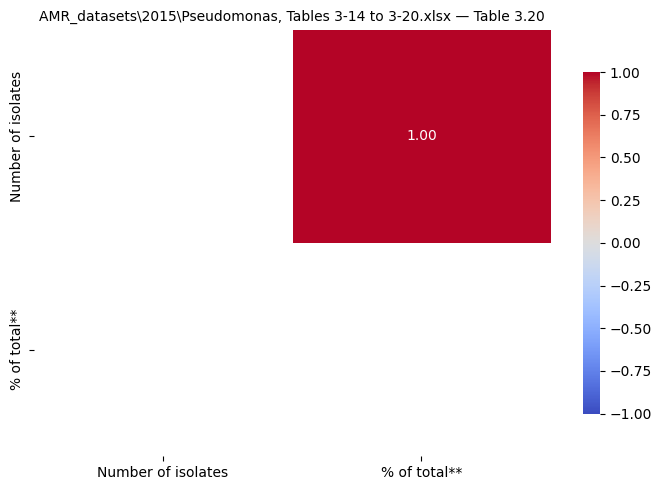

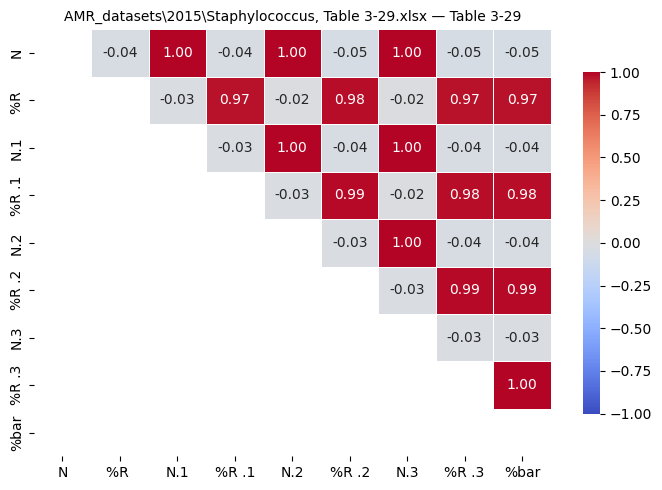

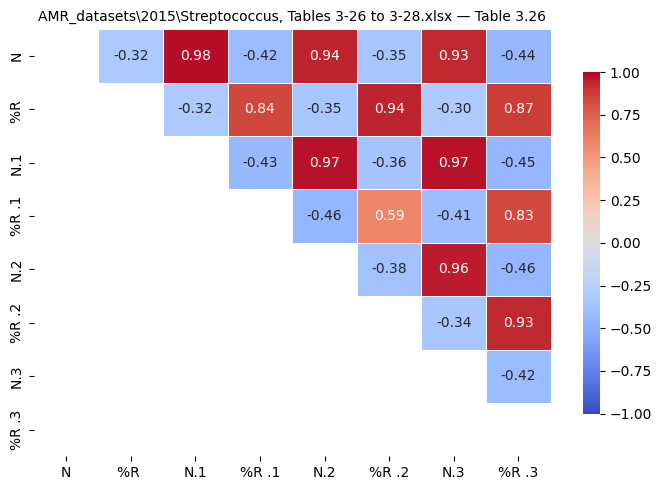

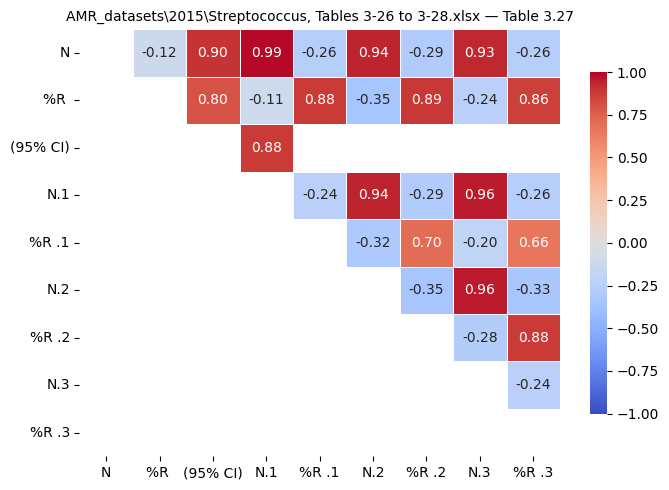

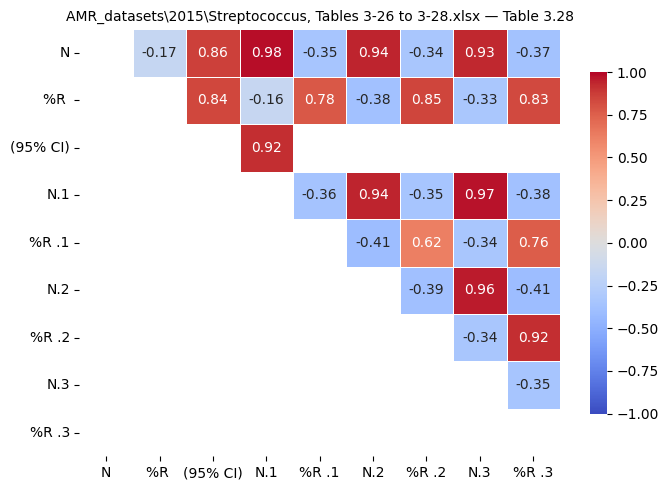

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

data = file_paths = [

    #2013
    
    #E-Coli
    r"data\raw\2013\E-Coli\number-3GCREC-percentage-ESBL-2013.xlsx",
    r"data\raw\2013\E-Coli\number-e-coli-isolates-and-percentage-combined-resistance-2010-2013.xlsx",
    r"data\raw\2013\E-Coli\number-e-coli-isolates-and-percentage-resistant-3-gen-cephalosporins-2010-2013.xlsx",
    r"data\raw\2013\E-Coli\number-e-coli-isolates-and-percentage-resistant-aminoglycosides-2010-2013.xlsx",
    r"data\raw\2013\E-Coli\number-e-coli-isolates-and-percentage-resistant-aminopenicilins-2010-2013.xlsx",
    r"data\raw\2013\E-Coli\number-e-coli-isolates-and-percentage-resistant-carbapenems-2010-2013.xlsx",
    r"data\raw\2013\E-Coli\number-e-coli-isolates-and-percentage-resistant-fluoroquinolones-2010-2013.xlsx",

    #Enterococci
    r"data\raw\2013\Enterococci\number-e-faecalis-isolates-and-percentage-high-level-resistance-aminoglycosides-2010-2013.xlsx",
    r"data\raw\2013\Enterococci\number-e-faecium-isolates-and-percentage-resistant-vancomycin-2010-2013.xlsx",

    #K-Pneumoniae
    r"data\raw\2013\K-Pneumoniae\number-3GCRKP-percentage-ESBL-2013.xlsx",
    r"data\raw\2013\K-Pneumoniae\number-k-pneumoniae-isolates-and-percentage-combined-resistance-2010-2013.xlsx",
    r"data\raw\2013\K-Pneumoniae\number-k-pneumoniae-isolates-and-percentage-resistant-3-gen-cephalosporins-2010-2013.xlsx",
    r"data\raw\2013\K-Pneumoniae\number-k-pneumoniae-isolates-and-percentage-resistant-aminoglycosides-2010-2013.xlsx",
    r"data\raw\2013\K-Pneumoniae\number-k-pneumoniae-isolates-and-percentage-resistant-carbapenems-2010-2013.xlsx",
    r"data\raw\2013\K-Pneumoniae\number-k-pneumoniae-isolates-and-percentage-resistant-fluoroquinolones-2010-2013.xlsx",

    #P-aeruginosa
    r"data\raw\2013\P-aeruginosa\number-p-aeruginosa-isolates-and-percentage-combined-resistance-2010-2013.xlsx",
    r"data\raw\2013\P-aeruginosa\number-p-aeruginosa-isolates-and-percentage-resistant-aminoglycosides-2010-2013.xlsx",
    r"data\raw\2013\P-aeruginosa\number-p-aeruginosa-isolates-and-percentage-resistant-carbapenems-2010-2013.xlsx",
    r"data\raw\2013\P-aeruginosa\number-p-aeruginosa-isolates-and-percentage-resistant-ceftazidime-2010-2013.xlsx",
    r"data\raw\2013\P-aeruginosa\number-p-aeruginosa-isolates-and-percentage-resistant-fluoroquinolones-2010-2013.xlsx",
    r"data\raw\2013\P-aeruginosa\number-p-aeruginosa-isolates-and-percentage-resistant-piperacillin-2010-2013.xlsx",

    #S-aureus
    r"data\raw\2013\S-aureus\number-s-aureus-isolates-and-percentage-resistant-meticilin-2010-2013.xlsx",

    #S-pneumoniae
    r"data\raw\2013\S-pneumoniae\number-s-pneumoniae-isolates-and-percentage-non-susceptible-macrolides-2010-2013.xlsx",
    r"data\raw\2013\S-pneumoniae\number-s-pneumoniae-isolates-and-percentage-non-susceptible-penicillin-2010-2013.xlsx",
    r"data\raw\2013\S-pneumoniae\number-s-pneumoniae-isolates-and-percentage-non-susceptible-penicillins-macrolides-2010-2013.xlsx",


       #2014
    
    #Acinetobacter
    r"data\raw\2014\Acinetobacter\acinetobacter-resistance-combinations-2014.xlsx",

    #E-Coli
    r"data\raw\2014\E-Coli\e-coli-resistance-combinations-2014.xlsx",
    r"data\raw\2014\E-Coli\number-3GCREC-percentage-ESBL-2014.xlsx",
    r"data\raw\2014\E-Coli\number-e-coli-isolates-and-percentage-combined-resistance-2011-2014.xlsx",
    r"data\raw\2014\E-Coli\number-e-coli-isolates-and-percentage-resistant-aminoglycosides-2011-2014.xlsx",
    r"data\raw\2014\E-Coli\number-e-coli-isolates-and-percentage-resistant-carbapenems-2011-2014.xlsx",
    r"data\raw\2014\E-Coli\number-e-coli-isolates-and-percentage-resistant-cephalosporins-2011-2014.xlsx",
    r"data\raw\2014\E-Coli\number-e-coli-isolates-and-percentage-resistant-fluoroquinolones-2011-2014.xlsx",

    #Enterococci
    r"data\raw\2014\Enterococci\number-e-faecalis-isolates-and-percentage-high-level-resistance-aminoglycosides-2011-2014.xlsx",
    r"data\raw\2014\Enterococci\number-e-faecium-isolates-and-percentage-resistant-vancomycin-2011-2014.xlsx",

    #K-Pneumoniae
    r"data\raw\2014\K-pneumoniae\k-pneumoniae-resistance-combinations-2014.xlsx",
    r"data\raw\2014\K-pneumoniae\number-3GCRKP-percentage-ESBL-2014.xlsx",
    r"data\raw\2014\K-pneumoniae\number-k-pneumoniae-isolates-and-percentage-combined-resistance-2011-2014.xlsx",
    r"data\raw\2014\K-pneumoniae\number-k-pneumoniae-isolates-and-percentage-resistant-carbapenems-2011-2014.xlsx",
    r"data\raw\2014\K-pneumoniae\number-k-pneumoniae-isolates-and-percentage-resistant-cephalosporins-2011-2014.xlsx",
    r"data\raw\2014\K-pneumoniae\number-k-pneumoniae-isolates-and-percentage-resistant-fluoroquinolones-2011-2014.xlsx",

    #P-aeruginosa
    r"data\raw\2014\P-aeruginosa\number-p-aeruginosa-isolates-and-percentage-combined-resistance-2011-2014.xlsx",
    r"data\raw\2014\P-aeruginosa\number-p-aeruginosa-isolates-and-percentage-resistant-aminoglycosides-2011-2014.xlsx",
    r"data\raw\2014\P-aeruginosa\number-p-aeruginosa-isolates-and-percentage-resistant-carbapenems-2011-2014.xlsx",
    r"data\raw\2014\P-aeruginosa\number-p-aeruginosa-isolates-and-percentage-resistant-ceftazidime-2011-2014.xlsx",
    r"data\raw\2014\P-aeruginosa\number-p-aeruginosa-isolates-and-percentage-resistant-fluoroquinolones-2011-2014.xlsx",
    r"data\raw\2014\P-aeruginosa\number-p-aeruginosa-isolates-and-percentage-resistant-piperacillin-2011-2014.xlsx",
    r"data\raw\2014\P-aeruginosa\p-aeruginosa-resistance-combinations-2014.xlsx",

    #S-aureus
    r"data\raw\2014\S-aureus\number-s-aureus-isolates-and-percentage-resistant-meticilin-2011-2014.xlsx",

    #S-pneumoniae
    r"data\raw\2014\S-pneumoniae\number-s-pneumoniae-isolates-and-percentage-non-susceptible-macrolides-2011-2014.xlsx",
    r"data\raw\2014\S-pneumoniae\number-s-pneumoniae-isolates-and-percentage-non-susceptible-penicillin-2011-2014.xlsx",
    r"data\raw\2014\S-pneumoniae\number-s-pneumoniae-isolates-and-percentage-non-susceptible-penicillins-macrolides-2011-2014.xlsx",


    #2015

    #Acinetobacter
    r"data\raw\2015\Acinetobacter, Tables 3-21 to 3-25.xlsx",

    #E-Coli
    r"data\raw\2015\E-coli, Tables 3-1 to 3-7.xlsx",

    #Enterococci
    r"data\raw\2015\Enterococci, Tables 3-30 and 3-31.xlsx",

    #K-Pneumoniae
    r"data\raw\2015\Klebsiella, Tables 3-8 to 3-13.xlsx",

    #P-aeruginosa
    r"data\raw\2015\Pseudomonas, Tables 3-14 to 3-20.xlsx",

    #S-aureus
    r"data\raw\2015\Staphylococcus, Table 3-29.xlsx",

    #S-pneumoniae
    r"data\raw\2015\Streptococcus, Tables 3-26 to 3-28.xlsx",
]

for file_path in file_paths:
    excel_file = pd.ExcelFile(file_path)

    for sheet in excel_file.sheet_names:
        std_header = 2
        df = pd.read_excel(file_path, header=std_header, sheet_name=sheet)

        if df.empty:
            continue
        
        while not df.empty and df.columns[0].startswith("Unnamed"):
            std_header += 1
            df = pd.read_excel(file_path, header=std_header, sheet_name=sheet)
        
        rename_dict = {}
        for col in df.columns:
            if col == "Number of":
                rename_dict[col] = "Number of isolates"
            elif col == "Number of.1":
                rename_dict[col] = "Number of laboratories"
        df = df.rename(columns=rename_dict)

        numeric_data = df.apply(pd.to_numeric, errors='coerce')
        numeric_data = numeric_data.select_dtypes(include=[np.number]).dropna(axis=1, how='all')
        numeric_data = numeric_data.loc[:, ~numeric_data.columns.str.startswith('Unnamed')]

        if numeric_data.empty:
            continue
        
        corr_matrix = numeric_data.corr(method="pearson").round(2)
        mask = np.tril(np.ones_like(corr_matrix, dtype=bool))

        plt.figure(figsize=(7, 5))
        sns.heatmap(
            corr_matrix,
            mask=mask, 
            cmap='coolwarm', 
            annot=True, 
            fmt=".2f", 
            linewidths=0.5,
            cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1
        )

        plt.title(f"{file_path} — {sheet}", fontsize=10)
        plt.tight_layout()
        plt.show()
    